# Example-01: Optimizaion (import/export API)

In [1]:
# Loading API facilitates (suboptimal) interface with different optimization libraries
# In this example, quadrupole gradients are used to fit beta functions

In [2]:
from pathlib import Path

from model.external import load_sdds
from model.external import load_lattice
from model.external import text_lattice

import numpy
from numpy import ndarray as Array

from scipy.optimize import minimize

In [3]:
# Set quadrupole gradient and compute and return twiss parameters

def evaluate(knobs:Array) -> Array:
    kf, kd = knobs
    path:Path = Path('optimize.lte')
    lattice:dict[str, dict[str, str | int | float | dict]] = load_lattice(path)
    lattice['QF']['K1'] = float(kf)
    lattice['QD']['K1'] = float(kd)
    with path.open('w') as stream:
        stream.write(text_lattice('LTE', lattice))
    !elegant 'optimize.ele' > /dev/null
    !sddsconvert -ascii 'binary.twiss' 'optimize.twiss'
    path:Path = Path('optimize.twiss')
    _, columns = load_sdds(path)
    return numpy.asarray([[data['betax'], data['betay']] for location, data in columns.items()]).T

In [4]:
# Set target beta functions

target:Array = numpy.asarray([+0.21, -0.19])
result:Array = evaluate(target)

In [5]:
# Set objetive function to minimize

def objective(knobs:Array) -> Array:
    return numpy.sum((evaluate(knobs) - result)**2)

objective(target)

0.0

In [6]:
# Optimize 

knobs:Array = numpy.asarray([+0.20, -0.20])

minimize(objective, knobs, method='Nelder-Mead')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.3489521479279302e-28
             x: [ 2.100e-01 -1.900e-01]
           nit: 20
          nfev: 40
 final_simplex: (array([[ 2.100e-01, -1.900e-01],
                       [ 2.100e-01, -1.900e-01],
                       [ 2.100e-01, -1.900e-01]]), array([ 1.349e-28,  2.891e-05,  6.010e-05]))

# Example-02: Workflow (MADX)

In [1]:
from pathlib import Path

from model.external import load_lattice
from model.external import rift_lattice
from model.external import text_lattice
from model.external import load_tfs
from model.external import convert
from model.external import add_rc

In [2]:
# Given some initial MADX lattice file (FODO)

file = Path('initial.madx')

with file.open('r') as stream:
    print(stream.read())

# Several regular elements are defined
# HEAD and TAIL should appear as the first and the last elements
# All elements should be defined on a single line with numerical parameters
# Lattice should be defined using lines
# Comma after element type is mandatory
# Comments appearing after definitions should also represent an element definition

DR: DRIFT, L=2.0;
BM: SBEND, L=1.0, ANGLE=0.17453292519943295;
QF: QUADRUPOLE, L=1.0, K1=+0.2;
QD: QUADRUPOLE, L=0.5, K1=-0.2;

M: MONITOR,;

HEAD: MARKER,; ! TEST: DRIFT,
TAIL: MARKER,; ! TEST: DRIFT,

FODO: LINE=(HEAD, M, QD, DR, BM, DR, QF, DR, BM, DR, QD, TAIL) ;



In [3]:
# If element and beamline definitions comply with the above requirements
# The lattice file can be loaded as a python dictionary

lattice = load_lattice(file)

for key, value in lattice.items():
    print(key, value)

# For each element and beamline, a key-value pair in created
# Value is itself a dictionary containing all information about the original elements
# Each element parameter is casted from string to int, float or string
# Comment after element definition is saved into RC (it has a special use case, see below)

DR {'KIND': 'DRIFT', 'RC': '', 'L': 2.0}
BM {'KIND': 'SBEND', 'RC': '', 'L': 1.0, 'ANGLE': 0.17453292519943295}
QF {'KIND': 'QUADRUPOLE', 'RC': '', 'L': 1.0, 'K1': 0.2}
QD {'KIND': 'QUADRUPOLE', 'RC': '', 'L': 0.5, 'K1': -0.2}
M {'KIND': 'MONITOR', 'RC': ''}
HEAD {'KIND': 'MARKER', 'RC': 'TEST: DRIFT,'}
TAIL {'KIND': 'MARKER', 'RC': 'TEST: DRIFT,'}
FODO {'KIND': 'LINE', 'SEQUENCE': ['HEAD', 'M', 'QD', 'DR', 'BM', 'DR', 'QF', 'DR', 'BM', 'DR', 'QD', 'TAIL']}


In [4]:
# Error lattice is defined by a set of linear transformations between selected locations
# Each locations can be a MONITOR (beam observation) or a VIRTUAL (error)
# Two special locatons (HEAD and TAIL) should present in the lattice
# Using the above dictionary representation, new observation locations can be inserted
# Locations are inserted at the middle of selected elements (selected by type or name)
# Selected elements are splitted in half and renamed, old names are binded to beamlines
# Original element definitions are added to created location RC
# Typicaly, monitor locations correspond to MONITOR elements, but new monitor elements can be also inserted
# Virtual locations can be inserted into quadrupole or other elements to represent errors

lattice = rift_lattice(lattice, 
                       'MONITOR', 
                       'MARKER', 
                       ['DRIFT'], 
                       ['SBEND', 'QUADRUPOLE'], 
                       exclude_virtual=['QD'])

for key, value in lattice.items():
    print(key, value)

M_DR {'KIND': 'MONITOR', 'RC': ['DR', {'KIND': 'DRIFT', 'L': 2.0}]}
H_DR {'KIND': 'DRIFT', 'L': 1.0}
DR {'KIND': 'LINE', 'SEQUENCE': ['H_DR', 'M_DR', 'H_DR']}
V_BM {'KIND': 'MARKER', 'RC': ['BM', {'KIND': 'SBEND', 'L': 1.0, 'ANGLE': 0.17453292519943295}]}
H_BM {'KIND': 'SBEND', 'L': 0.5, 'ANGLE': 0.08726646259971647}
BM {'KIND': 'LINE', 'SEQUENCE': ['H_BM', 'V_BM', 'H_BM']}
V_QF {'KIND': 'MARKER', 'RC': ['QF', {'KIND': 'QUADRUPOLE', 'L': 1.0, 'K1': 0.2}]}
H_QF {'KIND': 'QUADRUPOLE', 'L': 0.5, 'K1': 0.2}
QF {'KIND': 'LINE', 'SEQUENCE': ['H_QF', 'V_QF', 'H_QF']}
QD {'KIND': 'QUADRUPOLE', 'RC': '', 'L': 0.5, 'K1': -0.2}
M {'KIND': 'MONITOR', 'RC': ''}
HEAD {'KIND': 'MARKER', 'RC': 'TEST: DRIFT,'}
TAIL {'KIND': 'MARKER', 'RC': 'TEST: DRIFT,'}
FODO {'KIND': 'LINE', 'SEQUENCE': ['HEAD', 'M', 'QD', 'DR', 'BM', 'DR', 'QF', 'DR', 'BM', 'DR', 'QD', 'TAIL']}


In [5]:
# Modified lattice can be converted to text
# Comments are added to locations while original comments are preserved

text = text_lattice('MADX', lattice, rc=True)

print(text)

M_DR: MONITOR,; ! DR: DRIFT, L=2.0,;
H_DR: DRIFT, L=1.0,;
DR: LINE=(H_DR, M_DR, H_DR);
V_BM: MARKER,; ! BM: SBEND, L=1.0, ANGLE=0.17453292519943295,;
H_BM: SBEND, L=0.5, ANGLE=0.08726646259971647,;
BM: LINE=(H_BM, V_BM, H_BM);
V_QF: MARKER,; ! QF: QUADRUPOLE, L=1.0, K1=0.2,;
H_QF: QUADRUPOLE, L=0.5, K1=0.2,;
QF: LINE=(H_QF, V_QF, H_QF);
QD: QUADRUPOLE, L=0.5, K1=-0.2,;
M: MONITOR,;
HEAD: MARKER,; ! TEST: DRIFT,
TAIL: MARKER,; ! TEST: DRIFT,
FODO: LINE=(HEAD, M, QD, DR, BM, DR, QF, DR, BM, DR, QD, TAIL);



In [6]:
# Compute TWISS parameters using MADX
# TWISS command is appended to modified lattice

task = """
BEAM;
USE, PERIOD=FODO;
SET,FORMAT="20.20f","-20s";
TWISS;
WRITE,TABLE=TWISS,FILE="final.tfs";
RETURN;
""" ;

with Path('final.madx').open('w') as stream:
    stream.write(text)
    stream.write(task)

!madx final.madx > /dev/null

In [7]:
# Load lattice can be also loaded from file
# Original comments will be parsed as elements (look at HEAD and TAIL)
# Empty RC will be nested in this case

file = Path('final.madx')

with file.open('w') as stream:
    stream.write(text)

lattice = load_lattice(file, rc=True)

for key, value in lattice.items():
    print(key, value)

M_DR {'KIND': 'MONITOR', 'RC': ['DR', {'KIND': 'DRIFT', 'RC': '', 'L': 2.0}]}
H_DR {'KIND': 'DRIFT', 'RC': ['', {'KIND': '', 'RC': ''}], 'L': 1.0}
DR {'KIND': 'LINE', 'SEQUENCE': ['H_DR', 'M_DR', 'H_DR']}
V_BM {'KIND': 'MARKER', 'RC': ['BM', {'KIND': 'SBEND', 'RC': '', 'L': 1.0, 'ANGLE': 0.17453292519943295}]}
H_BM {'KIND': 'SBEND', 'RC': ['', {'KIND': '', 'RC': ''}], 'L': 0.5, 'ANGLE': 0.08726646259971647}
BM {'KIND': 'LINE', 'SEQUENCE': ['H_BM', 'V_BM', 'H_BM']}
V_QF {'KIND': 'MARKER', 'RC': ['QF', {'KIND': 'QUADRUPOLE', 'RC': '', 'L': 1.0, 'K1': 0.2}]}
H_QF {'KIND': 'QUADRUPOLE', 'RC': ['', {'KIND': '', 'RC': ''}], 'L': 0.5, 'K1': 0.2}
QF {'KIND': 'LINE', 'SEQUENCE': ['H_QF', 'V_QF', 'H_QF']}
QD {'KIND': 'QUADRUPOLE', 'RC': ['', {'KIND': '', 'RC': ''}], 'L': 0.5, 'K1': -0.2}
M {'KIND': 'MONITOR', 'RC': ['', {'KIND': '', 'RC': ''}]}
HEAD {'KIND': 'MARKER', 'RC': ['TEST', {'KIND': 'DRIFT', 'RC': ''}]}
TAIL {'KIND': 'MARKER', 'RC': ['TEST', {'KIND': 'DRIFT', 'RC': ''}]}
FODO {'KIND': '

In [8]:
# TWISS results can be loaded into python dictionaries

data = Path('final.tfs')
parameters, columns = load_tfs(data)

In [9]:
# Optics data can be converted into model table
# Note, all locations have different name
# If an element appear several times in a line, locations are renamed

table = convert(columns, 'TFS', ['MONITOR'], ['MARKER'], rc=True)
table

{'HEAD': {'TYPE': 'VIRTUAL',
  'S': 0.0,
  'BX': 4.287017735718936,
  'AX': -3.338e-16,
  'FX': 0.0,
  'BY': 19.818489282044894,
  'AY': -2.975e-17,
  'FY': 0.0,
  'DQX': 1.5490410441348796,
  'DPX': 5.551e-17,
  'DQY': 0.0,
  'DPY': -0.0,
  'RC': None},
 'M': {'TYPE': 'MONITOR',
  'S': 0.0,
  'BX': 4.287017735718936,
  'AX': -3.338e-16,
  'FX': 0.0,
  'BY': 19.818489282044894,
  'AY': -2.975e-17,
  'FY': 0.0,
  'DQX': 1.5490410441348796,
  'DPX': 5.551e-17,
  'DQY': 0.0,
  'DPY': -0.0,
  'RC': None},
 'M_DR': {'TYPE': 'MONITOR',
  'S': 1.5,
  'BX': 5.980356480296974,
  'AX': -0.8524040348462865,
  'FX': 0.3068185833848285,
  'BY': 15.315159900296642,
  'AY': 1.6491678474974667,
  'FY': 0.08453149247893033,
  'DQX': 1.744126900814982,
  'DPX': 0.1561982029636459,
  'DQY': 0.0,
  'DPY': 0.0,
  'RC': None},
 'V_BM': {'TYPE': 'VIRTUAL',
  'S': 3.0,
  'BX': 9.120629409698159,
  'AX': -1.1465687400023221,
  'FX': 0.5107301354647854,
  'BY': 10.914137614299745,
  'AY': 1.2848470098337954,
  

In [10]:
# RC parameter from lattice data can be added to model table
# Configuration table can be saved using util.save

table = add_rc(table, lattice)
table

{'HEAD': {'TYPE': 'VIRTUAL',
  'S': 0.0,
  'BX': 4.287017735718936,
  'AX': -3.338e-16,
  'FX': 0.0,
  'BY': 19.818489282044894,
  'AY': -2.975e-17,
  'FY': 0.0,
  'DQX': 1.5490410441348796,
  'DPX': 5.551e-17,
  'DQY': 0.0,
  'DPY': -0.0,
  'RC': None},
 'M': {'TYPE': 'MONITOR',
  'S': 0.0,
  'BX': 4.287017735718936,
  'AX': -3.338e-16,
  'FX': 0.0,
  'BY': 19.818489282044894,
  'AY': -2.975e-17,
  'FY': 0.0,
  'DQX': 1.5490410441348796,
  'DPX': 5.551e-17,
  'DQY': 0.0,
  'DPY': -0.0,
  'RC': None},
 'M_DR': {'TYPE': 'MONITOR',
  'S': 1.5,
  'BX': 5.980356480296974,
  'AX': -0.8524040348462865,
  'FX': 0.3068185833848285,
  'BY': 15.315159900296642,
  'AY': 1.6491678474974667,
  'FY': 0.08453149247893033,
  'DQX': 1.744126900814982,
  'DPX': 0.1561982029636459,
  'DQY': 0.0,
  'DPY': 0.0,
  'RC': ['DR', {'KIND': 'DRIFT', 'L': 2.0}]},
 'V_BM': {'TYPE': 'VIRTUAL',
  'S': 3.0,
  'BX': 9.120629409698159,
  'AX': -1.1465687400023221,
  'FX': 0.5107301354647854,
  'BY': 10.914137614299745,

# Example-03: Workflow (ELEGANT)

In [1]:
from pathlib import Path

from model.external import load_lattice
from model.external import rift_lattice
from model.external import text_lattice
from model.external import load_sdds
from model.external import convert
from model.external import add_rc

In [2]:
# Given some initial ELEGANT lattice file (FODO)

file = Path('initial.lte')

with file.open('r') as stream:
    print(stream.read())

# Several regular elements are defined
# HEAD and TAIL should appear as the first and the last elements
# All elements should be defined on a single line with numerical parameters
# Lattice should be defined using lines
# Comma after element type is mandatory
# Comments appearing after definitions should also represent an element definition

DR: DRIF,l=2

BM: CSBEND,angle=0.17453292519943295,fint=0,l=1.0
QD: QUAD,k1=-0.2,l=0.5
QF: QUAD,k1=0.2,l=1.0

M: MONI,

HEAD: MARK, ! TEST: DRIF,
TAIL: MARK, ! TEST: DRIF,

FODO: LINE=(HEAD, M, QD, DR, BM, DR, QF, DR, BM, DR, QD, TAIL)


In [3]:
# If element and beamline definitions comply with the above requirements
# The lattice file can be loaded as a python dictionary

lattice = load_lattice(file)

for key, value in lattice.items():
    print(key, value)

# For each element and beamline, a key-value pair in created
# Value is itself a dictionary containing all information about the original elements
# Each element parameter is casted from string to int, float or string
# Comment after element definition is saved into RC (it has a special use case, see below)

DR {'KIND': 'DRIF', 'RC': '', 'L': 2}
BM {'KIND': 'CSBEND', 'RC': '', 'ANGLE': 0.17453292519943295, 'FINT': 0, 'L': 1.0}
QD {'KIND': 'QUAD', 'RC': '', 'K1': -0.2, 'L': 0.5}
QF {'KIND': 'QUAD', 'RC': '', 'K1': 0.2, 'L': 1.0}
M {'KIND': 'MONI', 'RC': ''}
HEAD {'KIND': 'MARK', 'RC': 'TEST: DRIF,'}
TAIL {'KIND': 'MARK', 'RC': 'TEST: DRIF,'}
FODO {'KIND': 'LINE', 'SEQUENCE': ['HEAD', 'M', 'QD', 'DR', 'BM', 'DR', 'QF', 'DR', 'BM', 'DR', 'QD', 'TAIL']}


In [4]:
# Error lattice is defined by a set of linear transformations between selected locations
# Each locations can be a MONITOR (beam observation) or a VIRTUAL (error)
# Two special locatons (HEAD and TAIL) should present in the lattice
# Using the above dictionary representation, new observation locations can be inserted
# Locations are inserted at the middle of selected elements (selected by type or name)
# Selected elements are splitted in half and renamed, old names are binded to beamlines
# Original element definitions are added to created location RC
# Typicaly, monitor locations correspond to MONITOR elements, but new monitor elements can be also inserted
# Virtual locations can be inserted into quadrupole or other elements to represent errors

lattice = rift_lattice(lattice, 
                       'MONI', 
                       'MARK', 
                       ['DRIF'], 
                       ['CSBEND', 'QUAD'], 
                       exclude_virtual=['QD'])

for key, value in lattice.items():
    print(key, value)

M_DR {'KIND': 'MONI', 'RC': ['DR', {'KIND': 'DRIF', 'L': 2}]}
H_DR {'KIND': 'DRIF', 'L': 1.0}
DR {'KIND': 'LINE', 'SEQUENCE': ['H_DR', 'M_DR', 'H_DR']}
V_BM {'KIND': 'MARK', 'RC': ['BM', {'KIND': 'CSBEND', 'ANGLE': 0.17453292519943295, 'FINT': 0, 'L': 1.0}]}
H_BM {'KIND': 'CSBEND', 'ANGLE': 0.08726646259971647, 'FINT': 0, 'L': 0.5}
BM {'KIND': 'LINE', 'SEQUENCE': ['H_BM', 'V_BM', 'H_BM']}
QD {'KIND': 'QUAD', 'RC': '', 'K1': -0.2, 'L': 0.5}
V_QF {'KIND': 'MARK', 'RC': ['QF', {'KIND': 'QUAD', 'K1': 0.2, 'L': 1.0}]}
H_QF {'KIND': 'QUAD', 'K1': 0.2, 'L': 0.5}
QF {'KIND': 'LINE', 'SEQUENCE': ['H_QF', 'V_QF', 'H_QF']}
M {'KIND': 'MONI', 'RC': ''}
HEAD {'KIND': 'MARK', 'RC': 'TEST: DRIF,'}
TAIL {'KIND': 'MARK', 'RC': 'TEST: DRIF,'}
FODO {'KIND': 'LINE', 'SEQUENCE': ['HEAD', 'M', 'QD', 'DR', 'BM', 'DR', 'QF', 'DR', 'BM', 'DR', 'QD', 'TAIL']}


In [5]:
# Modified lattice can be converted to text
# Comments are added to locations while original comments are preserved

text = text_lattice('LTE', lattice, rc=True)

print(text)

M_DR: MONI, ! DR: DRIF, L=2,
H_DR: DRIF, L=1.0,
DR: LINE=(H_DR, M_DR, H_DR)
V_BM: MARK, ! BM: CSBEND, ANGLE=0.17453292519943295, FINT=0, L=1.0,
H_BM: CSBEND, ANGLE=0.08726646259971647, FINT=0, L=0.5,
BM: LINE=(H_BM, V_BM, H_BM)
QD: QUAD, K1=-0.2, L=0.5,
V_QF: MARK, ! QF: QUAD, K1=0.2, L=1.0,
H_QF: QUAD, K1=0.2, L=0.5,
QF: LINE=(H_QF, V_QF, H_QF)
M: MONI,
HEAD: MARK, ! TEST: DRIF,
TAIL: MARK, ! TEST: DRIF,
FODO: LINE=(HEAD, M, QD, DR, BM, DR, QF, DR, BM, DR, QD, TAIL)



In [6]:
# Compute TWISS parameters using ELEGANT
# Separate command file is created

with Path('final.lte').open('w') as stream:
    stream.write(text)

task = """
&run_setup
  use_beamline="FODO",
  lattice = "final.lte",
  p_central_mev = 1000
&end

&run_control
&end

&twiss_output
  filename = "binary.twiss",
  output_at_each_step = 1
&end

&bunched_beam
&end

&track
&end
""" ;

with Path('final.ele').open('w') as stream:
    stream.write(task)

!elegant final.ele > /dev/null
!sddsconvert -ascii binary.twiss final.twiss

In [7]:
# Load lattice can be also loaded from file
# Original comments will be parsed as elements (look at HEAD and TAIL)
# Empty RC will be nested in this case

file = Path('final.lte')

with file.open('w') as stream:
    stream.write(text)

lattice = load_lattice(file, rc=True)

for key, value in lattice.items():
    print(key, value)

M_DR {'KIND': 'MONI', 'RC': ['DR', {'KIND': 'DRIF', 'RC': '', 'L': 2}]}
H_DR {'KIND': 'DRIF', 'RC': ['', {'KIND': '', 'RC': ''}], 'L': 1.0}
DR {'KIND': 'LINE', 'SEQUENCE': ['H_DR', 'M_DR', 'H_DR']}
V_BM {'KIND': 'MARK', 'RC': ['BM', {'KIND': 'CSBEND', 'RC': '', 'ANGLE': 0.17453292519943295, 'FINT': 0, 'L': 1.0}]}
H_BM {'KIND': 'CSBEND', 'RC': ['', {'KIND': '', 'RC': ''}], 'ANGLE': 0.08726646259971647, 'FINT': 0, 'L': 0.5}
BM {'KIND': 'LINE', 'SEQUENCE': ['H_BM', 'V_BM', 'H_BM']}
QD {'KIND': 'QUAD', 'RC': ['', {'KIND': '', 'RC': ''}], 'K1': -0.2, 'L': 0.5}
V_QF {'KIND': 'MARK', 'RC': ['QF', {'KIND': 'QUAD', 'RC': '', 'K1': 0.2, 'L': 1.0}]}
H_QF {'KIND': 'QUAD', 'RC': ['', {'KIND': '', 'RC': ''}], 'K1': 0.2, 'L': 0.5}
QF {'KIND': 'LINE', 'SEQUENCE': ['H_QF', 'V_QF', 'H_QF']}
M {'KIND': 'MONI', 'RC': ['', {'KIND': '', 'RC': ''}]}
HEAD {'KIND': 'MARK', 'RC': ['TEST', {'KIND': 'DRIF', 'RC': ''}]}
TAIL {'KIND': 'MARK', 'RC': ['TEST', {'KIND': 'DRIF', 'RC': ''}]}
FODO {'KIND': 'LINE', 'SEQUEN

In [8]:
# TWISS results can be loaded into python dictionaries

data = Path('final.twiss')
parameters, columns = load_sdds(data)

In [9]:
# Optics data can be converted into model table
# Note, all locations have different name
# If an element appear several times in a line, locations are renamed

table = convert(columns, 'SDDS', ['MONI'], ['MARK'], rc=True)
table

{'HEAD': {'S': 0.0,
  'BX': 4.287017734831204,
  'AX': -1.321304551729011e-16,
  'FX': 0.0,
  'DQX': 1.549040841795901,
  'DPX': 2.775557561562891e-17,
  'BY': 19.81848926815186,
  'AY': 6.545730027929358e-16,
  'FY': 0.0,
  'DQY': 0.0,
  'DPY': 0.0,
  'TYPE': 'VIRTUAL',
  'RC': None},
 'M': {'S': 0.0,
  'BX': 4.287017734831204,
  'AX': -1.321304551729011e-16,
  'FX': 0.0,
  'DQX': 1.549040841795901,
  'DPX': 2.775557561562891e-17,
  'BY': 19.81848926815186,
  'AY': 6.545730027929358e-16,
  'FY': 0.0,
  'DQY': 0.0,
  'DPY': 0.0,
  'TYPE': 'MONITOR',
  'RC': None},
 'M_DR': {'S': 1.5,
  'BX': 5.980356479284525,
  'AX': -0.8524040348212205,
  'FX': 0.3068185834444499,
  'DQX': 1.744126672993481,
  'DPX': 0.1561981825607101,
  'BY': 15.31515988971357,
  'AY': 1.649167846239909,
  'FY': 0.08453149253790615,
  'DQY': 0.0,
  'DPY': 0.0,
  'TYPE': 'MONITOR',
  'RC': None},
 'V_BM': {'S': 3.0,
  'BX': 9.120629409314306,
  'AX': -1.146568740048648,
  'FX': 0.5107301355818847,
  'DQX': 1.9928963

In [10]:
# RC parameter from lattice data can be added to model table
# Configuration table can be saved using util.save

table = add_rc(table, lattice)
table

{'HEAD': {'S': 0.0,
  'BX': 4.287017734831204,
  'AX': -1.321304551729011e-16,
  'FX': 0.0,
  'DQX': 1.549040841795901,
  'DPX': 2.775557561562891e-17,
  'BY': 19.81848926815186,
  'AY': 6.545730027929358e-16,
  'FY': 0.0,
  'DQY': 0.0,
  'DPY': 0.0,
  'TYPE': 'VIRTUAL',
  'RC': None},
 'M': {'S': 0.0,
  'BX': 4.287017734831204,
  'AX': -1.321304551729011e-16,
  'FX': 0.0,
  'DQX': 1.549040841795901,
  'DPX': 2.775557561562891e-17,
  'BY': 19.81848926815186,
  'AY': 6.545730027929358e-16,
  'FY': 0.0,
  'DQY': 0.0,
  'DPY': 0.0,
  'TYPE': 'MONITOR',
  'RC': None},
 'M_DR': {'S': 1.5,
  'BX': 5.980356479284525,
  'AX': -0.8524040348212205,
  'FX': 0.3068185834444499,
  'DQX': 1.744126672993481,
  'DPX': 0.1561981825607101,
  'BY': 15.31515988971357,
  'AY': 1.649167846239909,
  'FY': 0.08453149253790615,
  'DQY': 0.0,
  'DPY': 0.0,
  'TYPE': 'MONITOR',
  'RC': ['DR', {'KIND': 'DRIF', 'L': 2}]},
 'V_BM': {'S': 3.0,
  'BX': 9.120629409314306,
  'AX': -1.146568740048648,
  'FX': 0.51073013

# Example-04: Transformations benchmark (PTC)

In [1]:
# In this example various symplectic transformations are compared with corresponding MADX-PTC transformations

In [2]:
# calibration

import torch

from model.library.transformations import calibration_forward
from model.library.transformations import calibration_inverse

gxx = torch.tensor(1.005, dtype=torch.float64)
gxy = torch.tensor(0.001, dtype=torch.float64)
gyx = torch.tensor(0.005, dtype=torch.float64)
gyy = torch.tensor(0.955, dtype=torch.float64)

state = torch.tensor([0.01, -0.005, -0.01, 0.005], dtype=torch.float64)

res = calibration_forward(state, gxx, gxy, gyx, gyy)
res = calibration_inverse(res, gxx, gxy, gyx, gyy)

print(state.tolist()) 
print(res.tolist())
print((state - res).tolist()) 

[0.01, -0.005, -0.01, 0.005]
[0.010000000000000002, -0.005, -0.010000000000000002, 0.005]
[-1.734723475976807e-18, 0.0, 1.734723475976807e-18, 0.0]


In [3]:
# drift

from pathlib import Path
from os import system

import torch
from model.library.transformations import drift

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(1.0, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.01, 0.005], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag:drift,l={length.item()} ;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)
res = drift(state, dp, length)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.005024875621890547, -0.005, -0.005024875621890547, 0.005]
[0.005024875621890547, -0.005, -0.005024875621890547, 0.005]
[0.0, 0.0, 0.0, 0.0]


In [4]:
# drift (with kinematic)

from pathlib import Path
from os import system

import torch
from model.library.transformations import drift
from model.library.transformations import kinematic

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(1.0, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.01, 0.005], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag:drift,l={length.item()} ;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=true ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)
state = drift(state, dp, length)
state = kinematic(state, dp, length)
res = state

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.005024752473723395, -0.005, -0.005024752473723395, 0.005]
[0.005024752473723394, -0.005, -0.005024752473723394, 0.005]
[8.673617379884035e-19, 0.0, -8.673617379884035e-19, 0.0]


In [5]:
# corrector

from pathlib import Path
from os import system

import torch
from model.library.transformations import corrector

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

dp = torch.tensor(0.005, dtype=torch.float64)
kx = -torch.tensor(0.1, dtype=torch.float64)
ky = +torch.tensor(0.1, dtype=torch.float64)
state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
magx:hkicker,l=0.0,kick={kx.item()};
magy:vkicker,l=0.0,kick={ky.item()};
map:line=(magx, magy) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)
res = corrector(state, kx, ky)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.0, -0.1, 0.0, 0.1]
[0.0, -0.1, 0.0, 0.1]
[0.0, 0.0, 0.0, 0.0]


In [6]:
# focusing quadrupole

from pathlib import Path
from os import system

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

import torch
from model.library.transformations import fquad

kn = torch.tensor(1.0, dtype=torch.float64)
dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(1.0, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.01, 0.005], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag:quadrupole,l={length.item()}, k1={kn.item()};
map:line=(mag) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)
res = fquad(state, kn.abs(), dp, length)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.0012338134845463512, -0.011134185772061586, -0.009559363509475737, -0.004042070986490389]
[0.0012338134845463642, -0.01113418577206157, -0.009559363509475702, -0.0040420709864903495]
[-1.3010426069826053e-17, -1.5612511283791264e-17, -3.469446951953614e-17, -3.9898639947466563e-17]


In [7]:
# defocusing quadrupole

from pathlib import Path
from os import system

import torch
from model.library.transformations import dquad

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

kn = torch.tensor(-1.0, dtype=torch.float64)
dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(1.0, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.01, 0.005], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag:quadrupole,l={length.item()}, k1={kn.item()};
map:line=(mag) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)
res = dquad(state, kn.abs(), dp, length)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.009559363509475737, 0.004042070986490389, -0.0012338134845463512, 0.011134185772061586]
[0.009559363509475702, 0.0040420709864903495, -0.0012338134845463642, 0.01113418577206157]
[3.469446951953614e-17, 3.9898639947466563e-17, 1.3010426069826053e-17, 1.5612511283791264e-17]


In [8]:
# generic quadrupole

from pathlib import Path
from os import system

import torch
from model.library.transformations import quadrupole

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

kn = torch.tensor(-1.0, dtype=torch.float64)
ks = torch.tensor(+1.0, dtype=torch.float64)
dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(1.0, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.01, 0.005], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag: quadrupole, l={length.item()},k1={kn.item()},k1s={ks.item()};
map:line=(mag) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)
res = quadrupole(state, kn, ks, dp, length)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.00576876084434182, -0.0020884471766207963, 0.002582224887596925, 0.017416187766128223]
[0.005768760844341825, -0.0020884471766207725, 0.0025822248875969544, 0.0174161877661282]
[-5.204170427930421e-18, -2.3852447794681098e-17, -2.949029909160572e-17, 2.42861286636753e-17]


In [9]:
# generic linear transformation

import torch
from model.library.transformations import quadrupole
from model.library.transformations import linear

kn = torch.tensor(-1.0, dtype=torch.float64)
ks = torch.tensor(+1.0, dtype=torch.float64)
dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(1.0, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.01, 0.005], dtype=torch.float64)

vector = torch.zeros_like(state)
matrix = torch.func.jacrev(quadrupole)(0.0*state, kn, ks, dp, length)

ref = quadrupole(state, kn, ks, dp, length)
res = linear(state, vector, matrix)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

[0.005768760844341825, -0.0020884471766207725, 0.0025822248875969544, 0.0174161877661282]
[0.005768760844341825, -0.0020884471766207725, 0.0025822248875969544, 0.0174161877661282]
[0.0, 0.0, 0.0, 0.0]


In [10]:
# quadrupole kick

from pathlib import Path
from os import system

import torch
from model.library.transformations import gradient

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

kn = torch.tensor(1.5, dtype=torch.float64)
ks = torch.tensor(1.0, dtype=torch.float64)
dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(1.0, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.05, 0.001], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag: multipole,knl={{0.0,{(kn*length).item()}}},ksl={{0.0,{(ks*length).item()}}};
map:line=(mag) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)
res = gradient(state, kn, ks, length)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.01, -0.07, -0.05, -0.06400000000000002]
[0.01, -0.07, -0.05, -0.06400000000000002]
[0.0, 0.0, 0.0, 0.0]


In [11]:
# sextupole kick

from pathlib import Path
from os import system

import torch
from model.library.transformations import sextupole

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

ks = torch.tensor(0.5, dtype=torch.float64)
dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(1.0, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.05, 0.001], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag: multipole,knl={{0.0,0.0,{(ks*length).item()}}};
map:line=(mag) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)
res = sextupole(state, ks, length)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.01, -0.0044, -0.05, 0.00075]
[0.01, -0.0044, -0.05, 0.00075]
[0.0, 0.0, 0.0, 0.0]


In [12]:
# octupole kick

import torch
from model.library.transformations import octupole

from pathlib import Path
from os import system

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

ko = torch.tensor(5.0, dtype=torch.float64)
dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(1.0, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.05, 0.001], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag: multipole,knl={{0.0,0.0,0.0,{(ko*length).item()}}};
map:line=(mag) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)
res = octupole(state, ko, length)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.01, -0.004938333333333334, -0.05, 0.0010916666666666668]
[0.01, -0.004938333333333334, -0.05, 0.0010916666666666668]
[0.0, 0.0, 0.0, 0.0]


In [13]:
# pure dipole (no edge effects if e1 = e2 = 0)

from pathlib import Path
from os import system

import torch
from model.library.transformations import dipole

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

angle = torch.tensor(0.1, dtype=torch.float64 )
dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(1.0, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.01, 0.005], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag: sbend, l={length.item()}, angle={angle.item()},k1=0.0,k1s=0.0,e1=0.0,e2=0.0,kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)
res = dipole(state, length/angle, dp, length)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.005231962156363519, -0.004575808017791941, -0.005024875621890682, 0.005]
[0.005231962156363559, -0.004575808017791928, -0.005024875621890547, 0.005]
[-3.9898639947466563e-17, -1.3010426069826053e-17, -1.3530843112619095e-16, 0.0]


In [14]:
# combined function dipole (no edge effects if e1 = e2 = 0)

from pathlib import Path
from os import system

import torch
from model.library.transformations import bend

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

angle = torch.tensor(0.1, dtype=torch.float64)
kn = torch.tensor(-1.0, dtype=torch.float64 )
ks = torch.tensor(0.5, dtype=torch.float64 )
dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(1.0, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.01, 0.005], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag: sbend, l={length.item()}, angle={angle.item()},k1={kn.item()},k1s={ks.item()},e1=0.0,e2=0.0,kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)
res = bend(state, length/angle, kn, ks, dp, length)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.007795176039169286, 0.0011097346020520168, 0.0007677684542948365, 0.01462661777023533]
[0.0077951760391692755, 0.0011097346020520064, 0.0007677684542948021, 0.014626617770235346]
[1.0408340855860843e-17, 1.0408340855860843e-17, 3.436920886779049e-17, -1.5612511283791264e-17]


In [15]:
# combined function dipole with edge effects

from pathlib import Path
from os import system

import torch
from model.library.transformations import bend
from model.library.transformations import wedge

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

angle = torch.tensor(0.1, dtype=torch.float64)
kn = torch.tensor(-1.0, dtype=torch.float64)
ks = torch.tensor(0.5, dtype=torch.float64)
dp = torch.tensor(0.005, dtype=torch.float64)
e1 = torch.tensor(0.02, dtype=torch.float64)
e2 = torch.tensor(-0.03, dtype=torch.float64)
length = torch.tensor(2.5, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.01, 0.005], dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag: sbend, l={length.item()}, angle={angle.item()},k1={kn.item()},k1s={ks.item()},e1={e1.item()},e2={e2.item()},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=false ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

state = wedge(state, e1, length/angle)
state = bend(state, length/angle, kn + 1.0E-16, ks + 1.0E-16, dp, length)
res = wedge(state, e2, length/angle)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.02505664248885726, 0.02888471799554683, 0.01948347950480536, 0.007752605073815676]
[0.025056642488857035, 0.028884717995546608, 0.019483479504805307, 0.007752605073815616]
[2.255140518769849e-16, 2.220446049250313e-16, 5.204170427930421e-17, 5.984795992119984e-17]


In [16]:
# translations (exact alignment, straight layout, act on a thin representation at the entrance frame)

from pathlib import Path
from os import system

import torch
from model.library.transformations import drift
from model.library.transformations import quadrupole
from model.library.transformations import tx, ty, tz

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

angle = torch.tensor(0.1, dtype=torch.float64)
kn = torch.tensor(-1.0, dtype=torch.float64)
ks = torch.tensor(0.5, dtype=torch.float64)
dp = torch.tensor(0.005, dtype=torch.float64)
length = torch.tensor(2.5, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.015, 0.0025], dtype=torch.float64)

dx = torch.tensor(0.01, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
dr: drift, l=1.0;
mag: quadrupole, l={length.item()},k1={kn.item()},k1s={ks.item()};
map:line=(dr, mag, dr) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
select,flag=error,pattern="mag";
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()};
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

state = drift(state, dp, 1.0)
state = tx(state, +dx)
state = ty(state, +dy)
state = tz(state, +dz, dp)
state = quadrupole(state, kn, ks, dp, length)
state = tz(state, -dz, dp)
state = ty(state, -dy)
state = tx(state, -dx)
state = drift(state, dp, 1.0)
res = state

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[-0.08749190399027759, -0.05149961687573391, -0.05640828383591964, -0.019912883990595223]
[-0.08749190399027745, -0.05149961687573378, -0.05640828383591953, -0.01991288399059518]
[-1.3877787807814457e-16, -1.249000902703301e-16, -1.1102230246251565e-16, -4.163336342344337e-17]


In [17]:
# translations + rotations (exact alignment, straight layout, act on a thin representation at the entrance frame)

from pathlib import Path
from os import system

import torch
from model.library.transformations import quadrupole
from model.library.transformations import tx, ty, tz
from model.library.transformations import rx, ry, rz

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

kn = torch.tensor(-1.0, dtype=torch.float64)
ks = torch.tensor(0.5, dtype=torch.float64)
dp = torch.tensor(0.005, dtype=torch.float64)

length = torch.tensor(2.5, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.015, 0.0025], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag:quadrupole,l={length.item()},k1={kn.item()},k1s={ks.item()};
map:line=(mag) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
select,flag=error,pattern="mag";
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()};
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

state = tx(state, +dx)
state = ty(state, +dy)
state = tz(state, +dz, dp)

state = rx(state, +wx, dp)
state = ry(state, +wy, dp)
state = rz(state, +wz)

state = quadrupole(state, kn + 1.0E-16, ks + 1.0E-16, dp, length)

state = tz(state, -length, dp)

state = rz(state, -wz)
state = ry(state, -wy, dp)
state = rx(state, -wx, dp)

state = tz(state, -dz, dp)
state = ty(state, -dy)
state = tx(state, -dx)

state = tz(state, +length, dp)

res = state

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[-0.19014967849021078, -0.2611883141418841, -0.10367399923762718, -0.09101974096085057]
[-0.19014967849022751, -0.2611883141418846, -0.10367399923763249, -0.09101974096085078]
[1.6736612096224235e-14, 4.996003610813204e-16, 5.3013149425851225e-15, 2.0816681711721685e-16]


In [18]:
# translations + rotations (exact alignment, curved layout, act on a thin representation at the entrance frame)

from pathlib import Path
from os import system

import torch
from model.library.transformations import bend
from model.library.transformations import wedge
from model.library.transformations import tx, ty, tz
from model.library.transformations import rx, ry, rz

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

angle = torch.tensor(0.1, dtype=torch.float64)
kn = torch.tensor(-1.0, dtype=torch.float64)
ks = torch.tensor(0.5, dtype=torch.float64)
dp = torch.tensor(0.005, dtype=torch.float64)
e1 = torch.tensor(0.005, dtype=torch.float64)
e2 = torch.tensor(0.005, dtype=torch.float64)

length = torch.tensor(2.5, dtype=torch.float64)
state = torch.tensor([0.01, -0.005, -0.015, 0.0025], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.01, dtype=torch.float64)

qx, px, qy, py = state.tolist()

code = f"""
mag:sbend,l={length.item()},angle={angle.item()},k1={kn.item()},k1s={ks.item()},e1={e1.item()},e2={e2.item()},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+9,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
select,flag=error,pattern="mag";
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()};
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=false ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp.item()},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

state = tx(state, +dx)
state = ty(state, +dy)
state = tz(state, +dz, dp)

state = rx(state, +wx, dp)
state = ry(state, +wy, dp)
state = rz(state, +wz)

state = wedge(state, e1, length/angle)
state = bend(state, length/angle, kn + 1.0E-16, ks + 1.0E-16, dp, length)
state = wedge(state, e2, length/angle)

state = ry(state, +angle/2, dp)
state = tz(state, -2.0*length/angle*(angle/2.0).sin(), dp)
state = ry(state, +angle/2, dp)

state = rz(state, -wz)
state = ry(state, -wy, dp)
state = rx(state, -wx, dp)

state = tz(state, -dz, dp)
state = ty(state, -dy)
state = tx(state, -dx)

state = ry(state, -angle/2, dp)
state = tz(state, +2.0*length/angle*(angle/2.0).sin(), dp)
state = ry(state, -angle/2, dp)

res = state

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[-0.20185873553633701, -0.27629369448112884, -0.08354566211146026, -0.06880534321809641]
[-0.20185873553633754, -0.2762936944811289, -0.08354566211146025, -0.06880534321809621]
[5.273559366969494e-16, 5.551115123125783e-17, -1.3877787807814457e-17, -1.942890293094024e-16]


In [19]:
# exact sector bend (without fringe)

from pathlib import Path
from os import system

import torch
from model.library.transformations import sector_bend

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

length = 2.5
angle = 0.1
e1 = 0.0
e2 = 0.0
dp = 0.005

state = torch.tensor([0.01, -0.0005, -0.01, 0.0005], dtype=torch.float64)
qx, px, qy, py = state.tolist()

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},kill_ent_fringe=true,kill_exi_fringe=true;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=true ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

length = torch.tensor(length, dtype=torch.float64)
angle = torch.tensor(angle, dtype=torch.float64)
e1 = torch.tensor(e1, dtype=torch.float64)
e2 = torch.tensor(e2, dtype=torch.float64)
dp = torch.tensor(dp, dtype=torch.float64)

state = sector_bend(state, length/angle, dp, length)
res = state

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.00932966343120269, -3.829320024990772e-05, -0.008755742622854638, 0.0005]
[0.009329663431209667, -3.829320024994158e-05, -0.008755742622854576, 0.0005]
[-6.977057820378718e-15, 3.386098909943791e-17, -6.245004513516506e-17, 0.0]


In [20]:
# exact sector bend (with fringe)

from pathlib import Path
from os import system

import torch
from model.library.transformations import sector_bend
from model.library.transformations import sector_bend_fringe

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

length = 2.5
angle = 0.1
e1 = 0.0
e2 = 0.0
dp = 0.005

state = torch.tensor([0.01, -0.0005, -0.01, 0.0005], dtype=torch.float64)
qx, px, qy, py = state.tolist()

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=true ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

length = torch.tensor(length, dtype=torch.float64)
angle = torch.tensor(angle, dtype=torch.float64)
e1 = torch.tensor(e1, dtype=torch.float64)
e2 = torch.tensor(e2, dtype=torch.float64)
dp = torch.tensor(dp, dtype=torch.float64)

state = sector_bend_fringe(state, +length/angle, dp)
state = sector_bend(state, length/angle, dp, length)
state = sector_bend_fringe(state, -length/angle, dp)
res = state

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.00933011773950498, -3.830113730822001e-05, -0.008756237750526722, 0.0004998143432367524]
[0.009330117739498277, -3.8301137308233764e-05, -0.008756237750526754, 0.0004998143432367524]
[6.702971511174383e-15, 1.3755815063409838e-17, 3.122502256758253e-17, 0.0]


In [21]:
# exact sector bend (with fringe and wedges)

from pathlib import Path
from os import system

import torch
from model.library.transformations import sector_bend
from model.library.transformations import sector_bend_fringe
from model.library.transformations import sector_bend_wedge
from model.library.transformations import polar

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

length = 2.5
angle = 0.1
e1 = 0.01
e2 = -0.01
dp = 0.005

state = torch.tensor([0.01, -0.0005, -0.01, 0.0005], dtype=torch.float64)
qx, px, qy, py = state.tolist()

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map  ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact=true ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=6,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}};
ptc_track_end;
ptc_end;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

length = torch.tensor(length, dtype=torch.float64)
angle = torch.tensor(angle, dtype=torch.float64)
e1 = torch.tensor(e1, dtype=torch.float64)
e2 = torch.tensor(e2, dtype=torch.float64)
dp = torch.tensor(dp, dtype=torch.float64)

state = polar(state, e1, dp)
state = sector_bend_fringe(state, +length/angle, dp)
state = sector_bend_wedge(state, -e1, length/angle, dp)
state = sector_bend(state, length/angle, dp, length)
state = sector_bend_wedge(state, -e2, length/angle, dp)
state = sector_bend_fringe(state, -length/angle, dp)
state = polar(state, e2, dp)
res = state

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.009340060895391944, -3.805697197357787e-05, -0.00874628326389246, 0.0005003157283896672]
[0.009340060895401722, -3.805697197360909e-05, -0.00874628326389242, 0.0005003157283896674]
[-9.778636234081262e-15, 3.1218246304004493e-17, -3.9898639947466563e-17, -1.0842021724855044e-19]


In [22]:
# linear wedge matrix

from model.library.transformations import wedge
from model.library.transformations import polar
from model.library.transformations import sector_bend_fringe
from model.library.transformations import sector_bend_wedge

length = 2.5
angle = 0.1
e1 = 0.01
e2 = -0.01
dp = 0.005

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

length = torch.tensor(length, dtype=torch.float64)
angle = torch.tensor(angle, dtype=torch.float64)
e1 = torch.tensor(e1, dtype=torch.float64)
e2 = torch.tensor(e2, dtype=torch.float64)
dp = torch.tensor(dp, dtype=torch.float64)

def wedge_entrance(state):
    state = polar(state, e1, dp)
    state = sector_bend_fringe(state, +length/angle, dp)
    state = sector_bend_wedge(state, -e1, length/angle, dp)
    return state

def wedge_exit(state):
    state = sector_bend_wedge(state, -e2, length/angle, dp)
    state = sector_bend_fringe(state, -length/angle, dp)
    state = polar(state, e2, dp)
    return state

print(torch.func.jacrev(wedge)(state, e1, length/angle))
print(torch.func.jacrev(wedge_entrance)(state))
print()

print(torch.func.jacrev(wedge)(state, e2, length/angle))
print(torch.func.jacrev(wedge_exit)(state))
print()

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 4.0001e-04,  1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -4.0001e-04,  1.0000e+00]],
       dtype=torch.float64)
tensor([[ 1.0000e+00,  5.5508e-17,  0.0000e+00,  0.0000e+00],
        [ 4.0001e-04,  1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -4.0001e-04,  1.0000e+00]],
       dtype=torch.float64)

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.0001e-04,  1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  4.0001e-04,  1.0000e+00]],
       dtype=torch.float64)
tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.0001e-04,  1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+

# Example-05: Drift (element)

In [1]:
# Comparison of drift element with MADX-PTC and other features

In [2]:
from pathlib import Path
from os import system

import torch
from model.library.drift import Drift

In [3]:
# Tracking (paraxial)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = False

dp = 0.005
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:drift,l={length} ;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Drift('D', length=length, dp=dp, exact=exact)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.0025373134328358204, -0.005, -0.003507462686567164, 0.001]
[0.0025373134328358204, -0.005, -0.0035074626865671645, 0.001]
[0.0, 0.0, 4.336808689942018e-19, 0.0]


In [4]:
# Tracking (exact)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = False

dp = 0.005
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:drift,l={length} ;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Drift('D', length=length, dp=dp, exact=exact)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.002537217378977325, -0.005, -0.003507443475795465, 0.001]
[0.002537217378977325, -0.005, -0.0035074434757954654, 0.001]
[0.0, 0.0, 4.336808689942018e-19, 0.0]


In [5]:
# Tracking (exact, alignment)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = True

dp = 0.005
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:drift,l={length} ;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Drift('D', length=length, dp=dp, exact=exact)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

# Note, for some reason drift is not invariant under WX ans WY rotations in MADX

[0.0025372170792497145, -0.0049999999999999975, -0.003507395297032926, 0.0010000000000000009]
[0.0025372170792497166, -0.004999999999999999, -0.0035073952970329247, 0.0010000000000000018]
[-2.168404344971009e-18, 1.734723475976807e-18, -1.3010426069826053e-18, -8.673617379884035e-19]


In [6]:
# Deviation/error variables

dp = 0.005
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Drift('D', length, dp)

# Each element has two variant of a call method
# In the first case only state is passed, it is transformed using parameters specified on initializaton

print(D(state))
print()

# Deviation errors can be also passed to call method
# These variables are added to corresponding parameters specified on initializaton
# For example, element lenght can changed

print(D(state, data={**D.table(), **{'dl': torch.tensor(-length, dtype=D.dtype)}}))
print()

# In the above D.table() creates default deviation dictionary (with zero values for each deviaton)
# {**D.table(), **{'dl': torch.tensor(-length, dtype=DR.dtype)}} replaces the 'dl' key value 

# Additionaly, alignment errors are passed as deivation variables
# They are used if alignment flag is raised

print(D(state, data={**D.table(), **error}, alignment=True))
print()

# The following elements can be made equivalent using deviation variables

DA = Drift('DA', length, dp)
DB = Drift('DB', length - 0.1, dp)

print(DA(state) - DB(state, data={**DB.table(), **{'dl': torch.tensor(+0.1, dtype=DB.dtype)}}))

tensor([ 0.0025, -0.0050, -0.0035,  0.0010], dtype=torch.float64)

tensor([ 0.0100, -0.0050, -0.0050,  0.0010], dtype=torch.float64)

tensor([ 0.0025, -0.0050, -0.0035,  0.0010], dtype=torch.float64)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [7]:
# Insertion element

# In this mode elements are treated as thin insertions (at the center)
# Using parameters specified on initialization, transport two matrices are computed
# These matrices are used to insert the element
# Input state is transformed from the element center to its entrance
# Next, transformation from the entrance frame to the exit frame is performed
# This transformation can contain errors
# The final step is to transform state from the exit frame back to the element center
# Without errors, this results in identity transformation for linear elements

dp = 0.0
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Drift('D', length, dp, exact=False, insertion=True)

# Identity transformation without errors

print(D(state) - state)

# Represents effect of an error

print(D(state, data={**D.table(), **{'dl': 0.1}}) - state)

# Exact tracking corresponds to inclusion of kinematic term as errors

D = Drift('D', length, dp, exact=True, insertion=True)

print(D(state) - state)

tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([-0.0005,  0.0000,  0.0001,  0.0000], dtype=torch.float64)
tensor([-9.7502e-08,  0.0000e+00,  1.9500e-08,  0.0000e+00],
       dtype=torch.float64)


In [8]:
# Mapping over a set of initial conditions

# Call method can be used to map over a set of initial conditions
# Note, device can be set to cpu or gpu via base element classvariables

dp = 0.0
length = 1.5

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Drift('D', length, dp, exact=True)

state = 1.0E-3*torch.randn((512, 4), dtype=D.dtype, device=D.device)

print(torch.vmap(D)(state).shape)

# To map over deviations parameters a wrapper function (or a lambda expression) can be used

def wrapper(state, dp):
    return D(state, data={**D.table(), **{'dp': dp}})

dp = 1.0E-3*torch.randn(512, dtype=D.dtype, device=D.device)

print(torch.vmap(wrapper)(state, dp).shape)

torch.Size([512, 4])
torch.Size([512, 4])


In [9]:
# Differentiability

# Both call methods are differentiable
# Derivative with respect to state can be computed directly
# For deviation variables, wrapping is required

dp = 0.0
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Drift('D', length, dp, exact=False)

# Compute derivative with respect to state

print(torch.func.jacrev(D)(state))
print()

# Compute derivative with respect to a deviation variable

dl = torch.tensor(0.0, dtype=torch.float64)

def wrapper(state, dl):
    return D(state, data={**D.table(), **{'dl': dl}})

print(torch.func.jacrev(wrapper, 1)(state, dl))
print()

# Compositional derivative (compute derivative of jacobian trace with respect momentum deviation)

dp = torch.tensor(0.0, dtype=torch.float64)

def trace(state, dp):
    return (torch.func.jacrev(lambda state: D(state, data={**D.table(), **{'dp': dp}}))(state)).trace()

torch.func.jacrev(trace, 1)(state, dp)

tensor([[1.0000, 1.5000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 1.5000],
        [0.0000, 0.0000, 0.0000, 1.0000]], dtype=torch.float64)

tensor([-0.0050,  0.0000,  0.0010,  0.0000], dtype=torch.float64)



tensor(-0., dtype=torch.float64)

In [10]:
# Output at each step

# It is possible to collect output of state or tangent matrix at each integration step
# Number of integratin steps is controlled by ns parameter on initialization
# Alternatively, desired integration step length can be passed
# Number of integration steps is computed as ceil(length/ds)

dp = 0.0
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Drift('D', length, dp, exact=False, ns=10, output=True, matrix=True)

# Final state is still returned

print(D(state))

# Data is added to special attributes (state and tangent matrix)

print(D.container_output.shape)
print(D.container_matrix.shape)

# Number of integration steps can be changed

D.ns = 100

D(state)
print(D.container_output.shape)
print(D.container_matrix.shape)

tensor([ 0.0025, -0.0050, -0.0035,  0.0010], dtype=torch.float64)
torch.Size([10, 4])
torch.Size([10, 4, 4])
torch.Size([100, 4])
torch.Size([100, 4, 4])


In [11]:
# Integration order is set on initialization (default value is zero)
# This order is related to difference order as 2n + 2
# Thus, zero corresponds to second order difference method

dp = 0.0
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Drift('D', length, dp, order=1, exact=True)

# For drift integration is performed only with exact flag
# In this case, kinematic term error is added
# This term actually commutes with paraxial drift map
# But integration is still performed for consistency with matrix-kick-matrix split
# Only one integration step is required to get exact result

D.ns = 1
ref = D(state)

D.ns = 10
res = D(state)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())
print()

# Integrator parameters are stored in data attribute (if integration is actually performed)

maps, weights = D._data
print(maps)
print(weights)

[0.002499902498098708, -0.005, -0.003499980499619743, 0.001]
[0.002499902498098709, -0.005, -0.0034999804996197477, 0.001]
[-8.673617379884035e-19, 0.0, 4.7704895589362195e-18, 0.0]

[0, 1, 0, 1, 0, 1, 0]
[0.6756035959798289, 1.3512071919596578, -0.17560359597982877, -1.7024143839193153, -0.17560359597982877, 1.3512071919596578, 0.6756035959798289]


# Example-06: Quadrupole (element)

In [1]:
# Comparison of quadrupole element with MADX-PTC and other features

In [2]:
from pathlib import Path
from os import system

import torch
from model.library.drift import Drift
from model.library.quadrupole import Quadrupole

In [3]:
# Tracking (paraxial)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = False

kn = - 2.0
ks = + 1.5
dp = 0.005
length = 1.0
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:quadrupole,l={length},k1={kn},k1s={ks} ;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

Q = Quadrupole('Q', length=length, kn=kn, ks=ks, dp=dp, exact=exact)
res = Q(state, alignment=align, data={**Q.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.012268608165994052, 0.012991610983278109, 0.005825218798687177, 0.01752224400608683]
[0.012268608165994057, 0.012991610983278092, 0.005825218798687172, 0.017522244006086807]
[-5.204170427930421e-18, 1.734723475976807e-17, 5.204170427930421e-18, 2.0816681711721685e-17]


In [4]:
# Tracking (exact)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = False

kn = - 2.0
ks = + 1.5
dp = 0.005
length = 1.0
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:quadrupole,l={length},k1={kn},k1s={ks} ;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

Q = Quadrupole('Q', length=length, kn=kn, ks=ks, dp=dp, exact=exact, order=5, ns=5)
res = Q(state, alignment=align, data={**Q.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.012269208914523159, 0.012992157908766264, 0.005826335256074007, 0.017521822791072554]
[0.01226920891452326, 0.012992157908766374, 0.005826335256074149, 0.017521822791072988]
[-1.0061396160665481e-16, -1.0928757898653885e-16, -1.4224732503009818e-16, -4.3368086899420177e-16]


In [5]:
# Tracking (exact, alignment)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = True

kn = - 2.0
ks = + 1.5
dp = 0.005
length = 1.0
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:quadrupole,l={length},k1={kn},k1s={ks} ;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

Q = Quadrupole('Q', length=length, kn=kn, ks=ks, dp=dp, exact=exact, order=5, ns=5)
res = Q(state, alignment=align, data={**Q.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[-0.022075488016794924, -0.09165584224601611, -0.04570124622656498, -0.08629975808408008]
[-0.02207548801679439, -0.09165584224601665, -0.04570124622656456, -0.08629975808408233]
[-5.342948306008566e-16, 5.412337245047638e-16, -4.2327252813834093e-16, 2.248201624865942e-15]


In [6]:
# Deviation/error variables

kn = - 2.0
ks = + 1.5
dp = 0.005
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

Q = Quadrupole('Q', length, kn, ks, dp)

# Each element has two variant of a call method
# In the first case only state is passed, it is transformed using parameters specified on initializaton

print(Q(state))
print()


# Deviation errors can be also passed to call method
# These variables are added to corresponding parameters specified on initializaton
# For example, element lenght can changed

print(Q(state, data={**Q.table(), **{'dl': -Q.length}}))
print()

# In the above Q.table() creates default deviation dictionary (with zero values for each deviaton)
# {**Q.table(), **{'dl': -Q.length}} replaces the 'dl' key value 

# Additionaly, alignment errors are passed as deivation variables
# They are used if alignment flag is raised

print(Q(state, data={**Q.table(), **error}, alignment=True))
print()

# The following elements can be made equivalent using deviation variables

QA = Quadrupole('QA', length, kn, ks, dp)
QB = Quadrupole('QB', length - 0.1, kn, ks, dp)

print(QA(state) - QB(state, data={**QB.table(), **{'dl': torch.tensor(+0.1, dtype=QB.dtype)}}))

# Note, while in some cases float values can be passed as values to deviation variables
# The correct behaviour in guaranteed only for tensors

tensor([0.0242, 0.0380, 0.0152, 0.0200], dtype=torch.float64)

tensor([ 0.0100, -0.0050, -0.0050,  0.0010], dtype=torch.float64)

tensor([-0.0908, -0.2335, -0.0963, -0.1316], dtype=torch.float64)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [7]:
# Insertion element

# In this mode elements are treated as thin insertions (at the center)
# Using parameters specified on initialization, transport two matrices are computed
# These matrices are used to insert the element
# Input state is transformed from the element center to its entrance
# Next, transformation from the entrance frame to the exit frame is performed
# This transformation can contain errors
# The final step is to transform state from the exit frame back to the element center
# Without errors, this results in identity transformation for linear elements

kn = - 2.0
ks = + 1.5
dp = 0.005
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

Q = Quadrupole('Q', length, kn, ks, dp, exact=False, insertion=True)

# Identity transformation without errors

print(Q(state) - state)

# Represents effect of an error

print(Q(state, data={**Q.table(), **{'dl': 0.1, 'kn': -0.1}}) - state)

# Exact tracking corresponds to inclusion of kinematic term as errors

Q = Quadrupole('Q', length, kn, ks, dp, exact=True, insertion=True, ns=100, order=1)

print(Q(state) - state)

tensor([-5.5511e-17,  7.4593e-17, -1.4745e-17,  2.7756e-17],
       dtype=torch.float64)
tensor([-0.0002,  0.0037,  0.0003,  0.0031], dtype=torch.float64)
tensor([-2.2924e-06, -3.9787e-06, -9.4215e-07,  2.1943e-07],
       dtype=torch.float64)


In [8]:
# Mapping over a set of initial conditions

# Call method can be used to map over a set of initial conditions
# Note, device can be set to cpu or gpu via base element classvariables

kn = - 2.0
ks = + 1.5
dp = 0.0
length = 1.5

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

Q = Quadrupole('Q', length, kn, ks, dp, exact=True)

state = 1.0E-3*torch.randn((512, 4), dtype=Q.dtype, device=Q.device)

print(torch.vmap(Q)(state).shape)

# To map over deviations parameters a wrapper function (or a lambda expression) can be used

def wrapper(state, dp):
    return Q(state, data={**Q.table(), **{'dp': dp}})

dp = 1.0E-3*torch.randn(512, dtype=Q.dtype, device=Q.device)

print(torch.vmap(wrapper)(state, dp).shape)

torch.Size([512, 4])
torch.Size([512, 4])


In [9]:
# Differentiability

# Both call methods are differentiable
# Derivative with respect to state can be computed directly
# For deviation variables, wrapping is required

kn = - 2.0
ks = + 1.5
dp = 0.0
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

Q = Quadrupole('Q', length, kn, ks, dp, exact=False)

# Compute derivative with respect to state

print(torch.func.jacrev(Q)(state))
print()

# Compute derivative with respect to a deviation variable

kn = torch.tensor(0.0, dtype=torch.float64)

def wrapper(state, kn):
    return Q(state, data={**Q.table(), **{'kn': kn}})

print(torch.func.jacrev(wrapper, 1)(state, kn))
print()

# Compositional derivative (compute derivative of jacobian trace with respect quadrupole strength)

length = 0.5
knf = +0.2
knd = -0.2

QF = Quadrupole('QF', length, knf)
QD = Quadrupole('QD', length, knd)
DR = Drift('DR', 5.0)

dknf = torch.tensor(0.0, dtype=torch.float64)
dknd = torch.tensor(0.0, dtype=torch.float64)
dkn = torch.stack([dknf, dknd])

def fodo(state, dkn):
    dknf, dknd = dkn
    state = QF(state, data={**QF.table(), **{'kn': dknf}})
    state = DR(state)
    state = QD(state, data={**QD.table(), **{'kn': dknd}})
    state = QD(state, data={**QD.table(), **{'kn': dknd}})
    state = DR(state)
    state = QF(state, data={**QF.table(), **{'kn': dknf}})
    return state

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

def trace(dkn):
    return (torch.func.jacrev(fodo)(state, dkn)).trace()

torch.func.jacrev(trace)(dkn)

tensor([[ 4.7923,  3.0672,  1.8367,  0.8757],
        [ 7.4479,  4.7923,  2.8495,  1.8367],
        [ 1.8367,  0.8757, -0.1057,  0.7321],
        [ 2.8495,  1.8367, -0.1507, -0.1057]], dtype=torch.float64)

tensor([-0.0175, -0.0354, -0.0029, -0.0029], dtype=torch.float64)



tensor([-12.7901,  12.7901], dtype=torch.float64)

In [10]:
# Output at each step

# It is possible to collect output of state or tangent matrix at each integration step
# Number of integratin steps is controlled by ns parameter on initialization
# Alternatively, desired integration step length can be passed
# Number of integration steps is computed as ceil(length/ds)

kn = - 2.0
ks = + 1.5
dp = 0.0
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

Q = Quadrupole('Q', length, kn, ks, dp, exact=False, ns=10, output=True, matrix=True)

# Final state is still returned

print(Q(state))

# Data is added to special attributes (state and tangent matrix)

print(Q.container_output.shape)
print(Q.container_matrix.shape)

# Number of integration steps can be changed

Q.ns = 100

Q(state)
print(Q.container_output.shape)
print(Q.container_matrix.shape)

tensor([0.0243, 0.0381, 0.0153, 0.0200], dtype=torch.float64)
torch.Size([10, 4])
torch.Size([10, 4, 4])
torch.Size([100, 4])
torch.Size([100, 4, 4])


In [11]:
# Integration order is set on initialization (default value is zero)
# This order is related to difference order as 2n + 2
# Thus, zero corresponds to second order difference method

kn = - 2.0
ks = + 1.5
dp = 0.0
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

Q = Quadrupole('Q', length, kn, ks, dp, order=1, exact=True)

# For quadrupole integration is performed only with exact flag
# In this case, kinematic term error is added

Q.ns = 1
ref = Q(state)

Q.ns = 10
res = Q(state)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())
print()

# Integrator parameters are stored in data attribute (if integration is actually performed)

maps, weights = Q._data
print(maps)
print(weights)

[0.02428427109202266, 0.038113543192801885, 0.015254854998694011, 0.019958320804526662]
[0.02428676414378537, 0.038112599406681553, 0.015255420211007745, 0.019958093271800193]
[-2.493051762711418e-06, 9.437861203318021e-07, -5.652123137335485e-07, 2.275327264690541e-07]

[0, 1, 0, 1, 0, 1, 0]
[0.6756035959798289, 1.3512071919596578, -0.17560359597982877, -1.7024143839193153, -0.17560359597982877, 1.3512071919596578, 0.6756035959798289]


In [12]:
# Derivatives of twiss parameters

# pip install git+https://github.com/i-a-morozov/twiss.git@main

from twiss import twiss

length = 0.5
knf = +0.21
knd = -0.19

QF = Quadrupole('QF', length, knf)
QD = Quadrupole('QD', length, knd)
DR = Drift('DR', 5.0)

dknf = torch.tensor(0.0, dtype=torch.float64)
dknd = torch.tensor(0.0, dtype=torch.float64)
dkn = torch.stack([dknf, dknd])

def fodo(state, dkn):
    dknf, dknd = dkn
    state = QF(state, data={**QF.table(), **{'kn': dknf}})
    state = DR(state)
    state = QD(state, data={**QD.table(), **{'kn': dknd}})
    state = QD(state, data={**QD.table(), **{'kn': dknd}})
    state = DR(state)
    state = QF(state, data={**QF.table(), **{'kn': dknf}})
    return state

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

def tune(dkn):
    matrix = torch.func.jacrev(fodo)(state, dkn)
    tune, *_ = twiss(matrix)
    return tune

# Compute tunes and jacobian

values = tune(dkn)
jacobian = torch.func.jacrev(tune)(dkn)

# Test jacobiant

print(values)
print(tune(dkn + 1.0E-3))
print(values + jacobian @ (dkn + 1.0E-3))

tensor([0.2107, 0.1703], dtype=torch.float64)
tensor([0.2126, 0.1681], dtype=torch.float64)
tensor([0.2126, 0.1681], dtype=torch.float64)


# Example-07: Sextupole (element)

In [1]:
# Comparison of sextupole element with MADX-PTC and other features

In [2]:
from pathlib import Path
from os import system

import torch
from model.library.drift import Drift
from model.library.quadrupole import Quadrupole
from model.library.sextupole import Sextupole

In [3]:
# Tracking (paraxial)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = False

ms = 10.0
dp = 0.005
length = 0.25
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag: sextupole, l={length},k2={ms} ;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

S = Sextupole('S', length=length, ms=ms, dp=dp, exact=exact, order=5, ns=10)
res = S(state, alignment=align, data={**S.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.008745689261382875, -0.005080234821325765, -0.00476590910682766, 0.0008855562050471031]
[0.008745689261382871, -0.00508023482132578, -0.00476590910682768, 0.0008855562050471008]
[3.469446951953614e-18, 1.5612511283791264e-17, 1.9949319973733282e-17, 2.2768245622195593e-18]


In [4]:
# Tracking (exact)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = False

ms = 10.0
dp = 0.005
length = 0.25
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag: sextupole, l={length},k2={ms} ;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

S = Sextupole('S', length=length, ms=ms, dp=dp, exact=exact, order=5, ns=10)
res = S(state, alignment=align, data={**S.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.008745672936611987, -0.005080234654232574, -0.004765906047078759, 0.000885556338827788]
[0.00874567293661202, -0.0050802346542325495, -0.0047659060470788064, 0.0008855563388277869]
[-3.2959746043559335e-17, -2.42861286636753e-17, 4.7704895589362195e-17, 1.0842021724855044e-18]


In [5]:
# Tracking (exact, alignment)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = True

ms = 10.0
dp = 0.005
length = 0.25
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag: sextupole, l={length},k2={ms} ;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

S = Sextupole('S', length=length, ms=ms, dp=dp, exact=exact, order=5, ns=10)
res = S(state, alignment=align, data={**S.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.008663885569968804, -0.006258052120536049, -0.004896687680053297, -0.000915022709372755]
[0.008663885569968922, -0.006258052120536033, -0.004896687680053253, -0.000915022709372733]
[-1.1796119636642288e-16, -1.6479873021779667e-17, -4.423544863740858e-17, -2.200930410145574e-17]


In [6]:
# Deviation/error variables

ms = 10.0
dp = 0.005
length = 0.25
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

S = Sextupole('S', length, ms, dp)

# Each element has two variant of a call method
# In the first case only state is passed, it is transformed using parameters specified on initializaton

print(S(state))
print()

# Deviation errors can be also passed to call method
# These variables are added to corresponding parameters specified on initializaton
# For example, element lenght can changed

print(S(state, data={**S.table(), **{'dl': -S.length}}))
print()

# In the above S.table() creates default deviation dictionary (with zero values for each deviaton)
# {**S.table(), **{'dl': -S.length}} replaces the 'dl' key value 

# Additionaly, alignment errors are passed as deivation variables
# They are used if alignment flag is raised

print(S(state, data={**S.table(), **error}, alignment=True))
print()

# The following elements can be made equivalent using deviation variables

SA = Sextupole('SA', length, ms, dp)
SB = Sextupole('SB', length - 0.1, ms, dp)

print(SA(state) - SB(state, data={**SB.table(), **{'dl': torch.tensor(+0.1, dtype=SB.dtype)}}))

# Note, while in some cases float values can be passed as values to deviation variables
# The correct behaviour in guaranteed only for tensors

tensor([ 0.0087, -0.0051, -0.0048,  0.0009], dtype=torch.float64)

tensor([ 0.0100, -0.0050, -0.0050,  0.0010], dtype=torch.float64)

tensor([ 0.0087, -0.0062, -0.0049, -0.0009], dtype=torch.float64)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [7]:
# Insertion element

# In this mode elements are treated as thin insertions (at the center)
# Using parameters specified on initialization, transport two matrices are computed
# These matrices are used to insert the element
# Input state is transformed from the element center to its entrance
# Next, transformation from the entrance frame to the exit frame is performed
# This transformation can contain errors
# The final step is to transform state from the exit frame back to the element center
# Without errors, this results in identity transformation for linear elements

ms = 10.0
dp = 0.005
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

S = Sextupole('S', length, ms, dp, exact=False, insertion=True)

# Since sextupole is a nonlinear element, insertion is an identity transformation only for zero strenght

print(S(state) - state)
print(S(state, data={**S.table(), **{'ms': -ms}}) - state)

# Represents effect of an error (any nonzero value of strengh or a change in other parameter)

print(S(state, data={**S.table(), **{'dl': 0.1}}) - state)

# Exact tracking corresponds to inclusion of kinematic term as errors

S = Sextupole('S', length, ms, dp, exact=True, insertion=True, ns=100, order=1)

print(S(state) - state)

tensor([ 0.0000, -0.0006,  0.0000, -0.0008], dtype=torch.float64)
tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([-5.2560e-04, -5.6465e-04,  6.1078e-05, -7.7234e-04],
       dtype=torch.float64)
tensor([-1.3875e-04, -5.5306e-04, -9.3764e-05, -7.7778e-04],
       dtype=torch.float64)


In [8]:
# Mapping over a set of initial conditions

# Call method can be used to map over a set of initial conditions
# Note, device can be set to cpu or gpu via base element classvariables

ms = 10.0
dp = 0.0
length = 1.5

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

S = Sextupole('S', length, ms, dp, exact=True)

state = 1.0E-3*torch.randn((512, 4), dtype=S.dtype, device=S.device)

print(torch.vmap(S)(state).shape)

# To map over deviations parameters a wrapper function (or a lambda expression) can be used

def wrapper(state, dp):
    return S(state, data={**S.table(), **{'dp': dp}})

dp = 1.0E-3*torch.randn(512, dtype=S.dtype, device=S.device)

print(torch.vmap(wrapper)(state, dp).shape)

torch.Size([512, 4])
torch.Size([512, 4])


In [9]:
# Differentiability

# Both call methods are differentiable
# Derivative with respect to state can be computed directly
# For deviation variables, wrapping is required

ms = 10.0
dp = 0.0
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

S = Sextupole('S', length, ms, dp, exact=False)

# Compute derivative with respect to state

print(torch.func.jacrev(S)(state))
print()

# Compute derivative with respect to a deviation variable

ms = torch.tensor(0.0, dtype=torch.float64)

def wrapper(state, ms):
    return S(state, data={**S.table(), **{'ms': ms}})

print(torch.func.jacrev(wrapper, 1)(state, ms))
print()

tensor([[ 0.9297,  1.4473, -0.0478, -0.0359],
        [-0.0938,  0.9297, -0.0638, -0.0478],
        [-0.0478, -0.0359,  1.0703,  1.5527],
        [-0.0638, -0.0478,  0.0938,  1.0703]], dtype=torch.float64)

tensor([-1.1813e-05, -1.5750e-05, -2.9883e-05, -3.9844e-05],
       dtype=torch.float64)



In [10]:
# Output at each step

# It is possible to collect output of state or tangent matrix at each integration step
# Number of integratin steps is controlled by ns parameter on initialization
# Alternatively, desired integration step length can be passed
# Number of integration steps is computed as ceil(length/ds)

ms = 10.0
dp = 0.0
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

S = Sextupole('S', length, ms, dp, exact=False, ns=10, output=True, matrix=True)

# Final state is still returned

print(S(state))

# Data is added to special attributes (state and tangent matrix)

print(S.container_output.shape)
print(S.container_matrix.shape)

# Number of integration steps can be changed

S.ns = 100

S(state)
print(S.container_output.shape)
print(S.container_matrix.shape)

tensor([ 0.0023, -0.0052, -0.0039,  0.0006], dtype=torch.float64)
torch.Size([10, 4])
torch.Size([10, 4, 4])
torch.Size([100, 4])
torch.Size([100, 4, 4])


In [11]:
# Integration order is set on initialization (default value is zero)
# This order is related to difference order as 2n + 2
# Thus, zero corresponds to second order difference method

ms = 10.0
dp = 0.0
length = 1.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

S = Sextupole('S', length, ms, dp, order=0, exact=True)

# For sextupole integration is always performed
# In exact case, kinematic term error is added

S.ns = 10
ref = S(state)

S.ns = 100
res = S(state)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())
print()

# Integrator parameters are stored in data attribute (if integration is actually performed)

maps, weights = S._data
print(maps)
print(weights)

[0.0022880403040043407, -0.005176627884407675, -0.0038882248469424585, 0.0005834231060909752]
[0.0022871610802911667, -0.005176794799148338, -0.0038891562083014203, 0.0005832353574511327]
[8.792237131739246e-07, 1.6691474066278522e-07, 9.313613589618727e-07, 1.877486398425181e-07]

[0, 1, 2, 1, 0]
[0.5, 0.5, 1.0, 0.5, 0.5]


In [12]:
# Derivatives of twiss parameters (chromaticity)

# pip install git+https://github.com/i-a-morozov/twiss.git@main

from twiss import twiss

QF = Quadrupole('QF', 0.5, +0.21)
QD = Quadrupole('QD', 0.5, -0.19)
SF = Sextupole('SF', 0.25)
SD = Sextupole('SD', 0.25)
DA = Drift('DR', 0.25)
DB = Drift('DR', 4.00)

def fodo(state, dp, dms):
    dmsf, dmsd = dms
    state = QF(state, data={**QF.table(), **{'dp': dp}})
    state = DA(state, data={**DA.table(), **{'dp': dp}})
    state = SF(state, data={**SF.table(), **{'dp': dp, 'ms': dmsf}})
    state = DB(state, data={**DB.table(), **{'dp': dp}})
    state = SD(state, data={**SD.table(), **{'dp': dp, 'ms': dmsd}})
    state = DA(state, data={**DA.table(), **{'dp': dp}})
    state = QD(state, data={**QD.table(), **{'dp': dp}})
    state = QD(state, data={**QD.table(), **{'dp': dp}})
    state = DA(state, data={**DA.table(), **{'dp': dp}})
    state = SD(state, data={**SD.table(), **{'dp': dp, 'ms': dmsd}})
    state = DB(state, data={**DB.table(), **{'dp': dp}})
    state = SF(state, data={**SF.table(), **{'dp': dp, 'ms': dmsf}})
    state = DA(state, data={**DA.table(), **{'dp': dp}})
    state = QF(state, data={**QF.table(), **{'dp': dp}})
    return state

dp = torch.tensor(0.0, dtype=torch.float64)

dmsf = torch.tensor(0.0, dtype=torch.float64)
dmsd = torch.tensor(0.0, dtype=torch.float64)
dms = torch.stack([dmsf, dmsd])

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

def tune(dp, dms):
    matrix = torch.func.jacrev(fodo)(state, dp, dms)
    tune, *_ = twiss(matrix)
    return tune

def chromaticity(dms):
    return torch.func.jacrev(tune)(dp, dms)

# Compute tunes

tunes = tune(dp, dms)
print(tunes)

# Compute chromaticity

chromaticities = chromaticity(dms)
print(chromaticities)

# Compute derivative of chromaticities 
# The result is zero, since there is no dispersion to feed sextupoles down

print(torch.func.jacrev(chromaticity)(dms))

tensor([0.2107, 0.1703], dtype=torch.float64)
tensor([-0.2279, -0.2107], dtype=torch.float64)
tensor([[0., 0.],
        [0., 0.]], dtype=torch.float64)


# Example-08: Octupole (element)

In [1]:
# Comparison of octupole element with MADX-PTC and other features

In [2]:
from pathlib import Path
from os import system

import torch
from model.library.octupole import Octupole

In [3]:
# Tracking (paraxial)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = False

mo = + 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag: octupole, l={length},k3={mo};
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

O = Octupole('O', length=length, mo=mo, dp=dp, exact=exact, order=5, ns=10)
res = O(state, alignment=align, data={**O.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.009004942132987458, -0.005000291994759593, -0.004801204788639501, 0.0009979801079392878]
[0.009004942132987486, -0.005000291994759635, -0.004801204788639504, 0.0009979801079392843]
[-2.7755575615628914e-17, 4.2500725161431774e-17, 3.469446951953614e-18, 3.469446951953614e-18]


In [4]:
# Tracking (exact)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = False

mo = + 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag: octupole, l={length},k3={mo};
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

O = Octupole('O', length=length, mo=mo, dp=dp, exact=exact, order=5, ns=10)
res = O(state, alignment=align, data={**O.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.00900492932570409, -0.005000291993307186, -0.004801202229721349, 0.0009979801112567327]
[0.009004929325704207, -0.0050002919933071705, -0.004801202229721335, 0.00099798011125672]
[-1.1622647289044608e-16, -1.5612511283791264e-17, -1.3877787807814457e-17, 1.2576745200831851e-17]


In [5]:
# Tracking (exact, alignment)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = True

mo = + 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag: octupole, l={length},k3={mo};
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

O = Octupole('O', length=length, mo=mo, dp=dp, exact=exact, order=5, ns=10)
res = O(state, alignment=align, data={**O.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.009005660276793346, -0.004983923494470567, -0.004794436076349048, 0.0011299481578555504]
[0.009005660276792638, -0.004983923494470562, -0.004794436076348805, 0.0011299481578555233]
[7.077671781985373e-16, -5.204170427930421e-18, -2.42861286636753e-16, 2.710505431213761e-17]


In [6]:
# Deviation/error variables

mo = 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

O = Octupole('O', length, mo, dp)

# Each element has two variant of a call method
# In the first case only state is passed, it is transformed using parameters specified on initializaton

print(O(state))
print()

# Deviation errors can be also passed to call method
# These variables are added to corresponding parameters specified on initializaton
# For example, element lenght can changed

print(O(state, data={**O.table(), **{'dl': -O.length}}))
print()

# In the above O.table() creates default deviation dictionary (with zero values for each deviaton)
# {**O.table(), **{'dl': -O.length}} replaces the 'dl' key value 

# Additionaly, alignment errors are passed as deivation variables
# They are used if alignment flag is raised

print(O(state, data={**O.table(), **error}, alignment=True))
print()

# The following elements can be made equivalent using deviation variables

OA = Octupole('OA', length, mo, dp)
OB = Octupole('OB', length - 0.1, mo, dp)

print(OA(state) - OB(state, data={**OB.table(), **{'dl': torch.tensor(+0.1, dtype=OB.dtype)}}))

# Note, while in some cases float values can be passed as values to deviation variables
# The correct behaviour in guaranteed only for tensors

tensor([ 0.0090, -0.0050, -0.0048,  0.0010], dtype=torch.float64)

tensor([ 0.0100, -0.0050, -0.0050,  0.0010], dtype=torch.float64)

tensor([ 0.0090, -0.0050, -0.0048,  0.0011], dtype=torch.float64)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [7]:
# Insertion element

# In this mode elements are treated as thin insertions (at the center)
# Using parameters specified on initialization, transport two matrices are computed
# These matrices are used to insert the element
# Input state is transformed from the element center to its entrance
# Next, transformation from the entrance frame to the exit frame is performed
# This transformation can contain errors
# The final step is to transform state from the exit frame back to the element center
# Without errors, this results in identity transformation for linear elements

mo = 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

O = Octupole('O', length, mo, dp, exact=False, insertion=True)

# Since octupole is a nonlinear element, insertion is an identity transformation only for zero strenght

print(O(state) - state)
print(O(state, data={**O.table(), **{'mo': -mo}}) - state)

# Represents effect of an error (any nonzero value of strengh or a change in other parameter)

print(O(state, data={**O.table(), **{'dl': 0.1}}) - state)

# Exact tracking corresponds to inclusion of kinematic term as errors

O = Octupole('O', length, mo, dp, exact=True, insertion=True, ns=100, order=1)

print(O(state) - state)

tensor([ 0.0000e+00, -4.1667e-07,  0.0000e+00, -2.2917e-06],
       dtype=torch.float64)
tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([-4.9754e-04, -5.2588e-07,  9.9342e-05, -3.2270e-06],
       dtype=torch.float64)
tensor([-1.7351e-08, -4.1976e-07, -6.9314e-09, -2.2953e-06],
       dtype=torch.float64)


In [8]:
# Mapping over a set of initial conditions

# Call method can be used to map over a set of initial conditions
# Note, device can be set to cpu or gpu via base element classvariables

mo = 50.0
dp = 0.005
length = 0.2

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

O = Octupole('O', length, mo, dp, exact=True)

state = 1.0E-3*torch.randn((512, 4), dtype=O.dtype, device=O.device)

print(torch.vmap(O)(state).shape)

# To map over deviations parameters a wrapper function (or a lambda expression) can be used

def wrapper(state, dp):
    return O(state, data={**O.table(), **{'dp': dp}})

dp = 1.0E-3*torch.randn(512, dtype=O.dtype, device=O.device)

print(torch.vmap(wrapper)(state, dp).shape)

torch.Size([512, 4])
torch.Size([512, 4])


In [9]:
# Differentiability

# Both call methods are differentiable
# Derivative with respect to state can be computed directly
# For deviation variables, wrapping is required

mo = 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

O = Octupole('O', length, mo, dp, exact=False)

# Compute derivative with respect to state

print(torch.func.jacrev(O)(state))
print()

# Compute derivative with respect to a deviation variable

mo = torch.tensor(0.0, dtype=torch.float64)

def wrapper(state, mo):
    return O(state, data={**O.table(), **{'mo': mo}})

print(torch.func.jacrev(wrapper, 1)(state, mo))
print()

tensor([[ 9.9997e-01,  1.9900e-01, -4.6335e-05, -4.6105e-06],
        [-3.3141e-04,  9.9997e-01, -4.6567e-04, -4.6335e-05],
        [-4.6335e-05, -4.6105e-06,  1.0000e+00,  1.9901e-01],
        [-4.6567e-04, -4.6335e-05,  3.3141e-04,  1.0000e+00]],
       dtype=torch.float64)

tensor([-5.7528e-10, -5.7815e-09, -4.0127e-09, -4.0327e-08],
       dtype=torch.float64)



In [10]:
# Output at each step

# It is possible to collect output of state or tangent matrix at each integration step
# Number of integratin steps is controlled by ns parameter on initialization
# Alternatively, desired integration step length can be passed
# Number of integration steps is computed as ceil(length/ds)

mo = 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

O = Octupole('O', length, mo, dp, exact=False, ns=10, output=True, matrix=True)

# Final state is still returned

print(O(state))

# Data is added to special attributes (state and tangent matrix)

print(O.container_output.shape)
print(O.container_matrix.shape)

# Number of integration steps can be changed

O.ns = 100

O(state)
print(O.container_output.shape)
print(O.container_matrix.shape)

tensor([ 0.0090, -0.0050, -0.0048,  0.0010], dtype=torch.float64)
torch.Size([10, 4])
torch.Size([10, 4, 4])
torch.Size([100, 4])
torch.Size([100, 4, 4])


In [11]:
# Integration order is set on initialization (default value is zero)
# This order is related to difference order as 2n + 2
# Thus, zero corresponds to second order difference method

mo = 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

O = Octupole('O', length, mo, dp, order=0, exact=True)

# For octupole integration is always performed
# In exact case, kinematic term error is added

O.ns = 10
ref = O(state)

O.ns = 100
res = O(state)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())
print()

# Integrator parameters are stored in data attribute (if integration is actually performed)

maps, weights = O._data
print(maps)
print(weights)

[0.00900492936806216, -0.005000291964120008, -0.004801202138358545, 0.0009979801465156844]
[0.00900492932612774, -0.005000291993015304, -0.004801202228807697, 0.0009979801116093128]
[4.193442121325219e-11, 2.889529587823958e-11, 9.044915164069245e-11, 3.4906371629978006e-11]

[0, 1, 2, 1, 0]
[0.5, 0.5, 1.0, 0.5, 0.5]


# Example-09: Multipole (element)

In [1]:
# Comparison of sextupole element with MADX-PTC and other features

In [2]:
from pathlib import Path
from os import system

import torch
from model.library.multipole import Multipole

In [3]:
# Tracking (paraxial)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = False

kn = - 2.0
ks = + 1.5
ms = 25.0
mo = 110.0
dp = 0.005
length = 0.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:quadrupole,l={length},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}};
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

M = Multipole('M', length=length, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=5, ns=10)
res = M(state, alignment=align, data={**M.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.00892946929535585, 0.0009165531774213284, -0.0017930189940976037, 0.01128986832436645]
[0.008929469295357165, 0.0009165531774215092, -0.001793018994097765, 0.011289868324367684]
[-1.3149203947904198e-15, -1.8084492237058214e-16, 1.6132928326584306e-16, -1.2333883914195098e-15]


In [4]:
# Tracking (exact)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = False

kn = - 2.0
ks = + 1.5
ms = 25.0
mo = 110.0
dp = 0.005
length = 0.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:quadrupole,l={length},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}};
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

M = Multipole('M', length=length, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=5, ns=10)
res = M(state, alignment=align, data={**M.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.00892945162589142, 0.0009165626425029898, -0.0017929090323601758, 0.011289834389170184]
[0.008929451625892749, 0.0009165626425031966, -0.0017929090323603035, 0.011289834389171444]
[-1.3287981825982342e-15, -2.067573542929857e-16, 1.2771901591879242e-16, -1.259409243559162e-15]


In [5]:
# Tracking (exact, alignment)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = True

kn = - 2.0
ks = + 1.5
ms = 25.0
mo = 110.0
dp = 0.005
length = 0.5
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:quadrupole,l={length},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}};
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

M = Multipole('M', length=length, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=5, ns=10)
res = M(state, alignment=align, data={**M.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.001664975746516068, -0.04016261215593401, -0.015906155451718536, -0.05363979979736713]
[0.001664975746510186, -0.040162612155939637, -0.015906155451718453, -0.053639799797374155]
[5.882013626168359e-15, 5.627442956068762e-15, -8.326672684688674e-17, 7.022160630754115e-15]


In [6]:
# Deviation/error variables

kn = - 2.0
ks = + 1.5
ms = 25.0
mo = 110.0
mo = 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

M = Multipole('M', length, kn, ks, ms, mo, dp)

# Each element has two variant of a call method
# In the first case only state is passed, it is transformed using parameters specified on initializaton

print(M(state))
print()

# Deviation errors can be also passed to call method
# These variables are added to corresponding parameters specified on initializaton
# For example, element lenght can changed

print(M(state, data={**M.table(), **{'dl': -M.length}}))
print()

# In the above M.table() creates default deviation dictionary (with zero values for each deviaton)
# {**M.table(), **{'dl': -M.length}} replaces the 'dl' key value 

# Additionaly, alignment errors are passed as deivation variables
# They are used if alignment flag is raised

print(M(state, data={**M.table(), **error}, alignment=True))
print()

# The following elements can be made equivalent using deviation variables

MA = Multipole('MA', length, kn, ks, ms, mo, dp)
MB = Multipole('MB', length - 0.1, kn, ks, ms, mo, dp)

print(MA(state) - MB(state, data={**MB.table(), **{'dl': torch.tensor(+0.1, dtype=MB.dtype)}}))

# Note, while in some cases float values can be passed as values to deviation variables
# The correct behaviour in guaranteed only for tensors

tensor([ 0.0092, -0.0028, -0.0043,  0.0055], dtype=torch.float64)

tensor([ 0.0100, -0.0050, -0.0050,  0.0010], dtype=torch.float64)

tensor([ 0.0085, -0.0159, -0.0060, -0.0224], dtype=torch.float64)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [7]:
# Insertion element

# In this mode elements are treated as thin insertions (at the center)
# Using parameters specified on initialization, transport two matrices are computed
# These matrices are used to insert the element
# Input state is transformed from the element center to its entrance
# Next, transformation from the entrance frame to the exit frame is performed
# This transformation can contain errors
# The final step is to transform state from the exit frame back to the element center
# Without errors, this results in identity transformation for linear elements

kn = - 2.0
ks = + 1.5
ms = 25.0
mo = 110.0
mo = 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

M = Multipole('M', length, kn, ks, ms, mo, dp, exact=False, insertion=True)

# Since multipole is a nonlinear element (non-zero sextupole or octupole)
# Insertion is an identity transformation only for zero strenght

print(M(state) - state)
print(M(state, data={**M.table(), **{'ms': -ms, 'mo': -mo}}) - state)

# Represents effect of an error (any nonzero value of strengh or a change in other parameter)

print(M(state, data={**M.table(), **{'dl': 0.1}}) - state)

# Exact tracking corresponds to inclusion of kinematic term as errors

M = Multipole('M', length, kn, ks, ms, mo, dp, exact=True, insertion=True, ns=20, order=1)

print(M(state) - state)

tensor([ 6.9389e-18, -1.8792e-04, -8.6736e-19, -2.5229e-04],
       dtype=torch.float64)
tensor([ 6.9389e-18, -1.7347e-18, -8.6736e-19, -4.3368e-19],
       dtype=torch.float64)
tensor([-0.0004,  0.0009,  0.0002,  0.0021], dtype=torch.float64)
tensor([-7.9785e-07, -1.9093e-04, -5.6642e-07, -2.5071e-04],
       dtype=torch.float64)


In [8]:
# Mapping over a set of initial conditions

# Call method can be used to map over a set of initial conditions
# Note, device can be set to cpu or gpu via base element classvariables

kn = - 2.0
ks = + 1.5
ms = 25.0
mo = 110.0
mo = 50.0
dp = 0.005
length = 0.2

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

M = Multipole('M', length, kn, ks, ms, mo, dp, exact=True)

state = 1.0E-3*torch.randn((512, 4), dtype=M.dtype, device=M.device)

print(torch.vmap(M)(state).shape)

# To map over deviations parameters a wrapper function (or a lambda expression) can be used

def wrapper(state, dp):
    return M(state, data={**M.table(), **{'dp': dp}})

dp = 1.0E-3*torch.randn(512, dtype=M.dtype, device=M.device)

print(torch.vmap(wrapper)(state, dp).shape)

torch.Size([512, 4])
torch.Size([512, 4])


In [9]:
# Differentiability

# Both call methods are differentiable
# Derivative with respect to state can be computed directly
# For deviation variables, wrapping is required

kn = - 2.0
ks = + 1.5
ms = 25.0
mo = 110.0
mo = 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

M = Multipole('M', length, kn, ks, ms, mo, dp, exact=False)

# Compute derivative with respect to state

print(torch.func.jacrev(M)(state))
print()

# Compute derivative with respect to a deviation variable

kn = torch.tensor(0.0, dtype=torch.float64)

def wrapper(state, kn):
    return M(state, data={**M.table(), **{'kn': kn}})

print(torch.func.jacrev(wrapper, 1)(state, kn))
print()

tensor([[ 1.0353,  0.2012,  0.0274,  0.0017],
        [ 0.3588,  1.0353,  0.2757,  0.0274],
        [ 0.0274,  0.0017,  0.9653,  0.1969],
        [ 0.2757,  0.0274, -0.3449,  0.9653]], dtype=torch.float64)

tensor([-1.9468e-04, -1.9487e-03, -9.6920e-05, -9.5528e-04],
       dtype=torch.float64)



In [10]:
# Output at each step

# It is possible to collect output of state or tangent matrix at each integration step
# Number of integratin steps is controlled by ns parameter on initialization
# Alternatively, desired integration step length can be passed
# Number of integration steps is computed as ceil(length/ds)

kn = - 2.0
ks = + 1.5
ms = 25.0
mo = 110.0
mo = 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

M = Multipole('M', length, kn, ks, ms, mo, dp, exact=False, ns=10, output=True, matrix=True)

# Final state is still returned

print(M(state))

# Data is added to special attributes (state and tangent matrix)

print(M.container_output.shape)
print(M.container_matrix.shape)

# Number of integration steps can be changed

M.ns = 100

M(state)
print(M.container_output.shape)
print(M.container_matrix.shape)

tensor([ 0.0092, -0.0028, -0.0043,  0.0055], dtype=torch.float64)
torch.Size([10, 4])
torch.Size([10, 4, 4])
torch.Size([100, 4])
torch.Size([100, 4, 4])


In [11]:
# Integration order is set on initialization (default value is zero)
# This order is related to difference order as 2n + 2
# Thus, zero corresponds to second order difference method

kn = - 2.0
ks = + 1.5
ms = 25.0
mo = 110.0
mo = 50.0
dp = 0.005
length = 0.2
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

M = Multipole('M', length, kn, ks, ms, mo, dp, order=0, exact=True)

# For multipole with non-zero sextupole and/or octupole integration is always performed
# In exact case, kinematic term error is added

M.ns = 10
ref = M(state)

M.ns = 100
res = M(state)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())
print()

# Integrator parameters are stored in data attribute (if integration is actually performed)

maps, weights = M._data
print(maps)
print(weights)

[0.009228705737231328, -0.0027662827194168435, -0.0043416399485996455, 0.0055422008499342295]
[0.009228699312521689, -0.0027663108074714327, -0.0043416467924913375, 0.0055422142138782556]
[6.424709639296644e-09, 2.808805458923494e-08, 6.843891692080717e-09, -1.336394402605412e-08]

[0, 1, 2, 1, 0]
[0.5, 0.5, 1.0, 0.5, 0.5]


# Example-10: Dipole (element)

In [1]:
# Comparison of dipole element with MADX-PTC and other features

# Note, cylindrical multipole is included upto octupole order
# Potential is not truncated in paraxial case, only sqrt is expanded 
# In exact case effects of multipoles are not accounted in wedges (cases with e1 or e2 not equal to zero)

In [2]:
from pathlib import Path
from os import system

import torch
from model.library.drift import Drift
from model.library.quadrupole import Quadrupole
from model.library.sextupole import Sextupole
from model.library.dipole import Dipole

In [3]:
# Tracking (paraxial)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = False

length = 2.0
angle = 0.05
e1 = 0.0
e2 = 0.0
kn = 0.0
ks = 0.0
ms = 0.0
mo = 0.0
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=5,sector_nmul=5 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Dipole('D', length=length, angle=angle, e1=e1, e2=e2, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=2, ns=25)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[5.160257777686003e-05, -0.004956273150572646, -0.0030019980019983517, 0.001]
[5.160257777670049e-05, -0.004956273150572624, -0.003001998001997979, 0.001]
[1.5954034968124198e-16, -2.2551405187698492e-17, -3.725318664660193e-16, 0.0]


In [4]:
# Tracking (paraxial, e1 & e2)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = False

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
kn = 0.0
ks = 0.0
ms = 0.0
mo = 0.0
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=5,sector_nmul=5 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Dipole('D', length=length, angle=angle, e1=e1, e2=e2, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=2, ns=25)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[6.408749411377232e-05, -0.00494998958983017, -0.002995752944647053, 0.0010049983869644134]
[6.408749411361558e-05, -0.0049499895898301935, -0.002995752944646423, 0.001004998386964413]
[1.5673497655993573e-16, 2.3418766925686896e-17, -6.29704621779581e-16, 4.336808689942018e-19]


In [5]:
# Tracking (paraxial, e1 & e2, alignment)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = True

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
kn = 0.0
ks = 0.0
ms = 0.0
mo = 0.0
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=5,sector_nmul=5 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Dipole('D', length=length, angle=angle, e1=e1, e2=e2, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=2, ns=25)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.0027250502286323983, -0.004697460778410744, -0.007781317874336121, -0.004015687563474919]
[0.0027250502286329382, -0.004697460778410177, -0.007781317874339214, -0.004015687563475917]
[-5.399326818977812e-16, -5.672545766444159e-16, 3.093011957666647e-15, 9.983333604246525e-16]


In [6]:
# Tracking (paraxial, kn & ks)

# Note, in paraxial case, MADX seems to truncate cylindrical potential

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = False

length = 2.0
angle = 0.05
e1 = 0.0
e2 = 0.0
kn = 0.1
ks = 0.1
ms = 0.0
mo = 0.0
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=5,sector_nmul=5 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Dipole('D', length=length, angle=angle, e1=e1, e2=e2, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=2, ns=25)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[-0.002043638956596164, -0.006566087436123452, -0.00259447159458907, 0.0010855376916213359]
[-0.002044085292481253, -0.006566346702412594, -0.0025944404024843, 0.0010855252766681649]
[4.4633588508913996e-07, 2.5926628914162836e-07, -3.11921047697547e-08, 1.2414953170971493e-08]


In [7]:
# Tracking (paraxial, kn & ks, alignment)

# Note, in paraxial case, MADX seems to truncate cylindrical potential

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = True

length = 2.0
angle = 0.05
e1 = 0.0
e2 = 0.0
kn = 0.1
ks = 0.1
ms = 0.0
mo = 0.0
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=5,sector_nmul=5 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Dipole('D', length=length, angle=angle, e1=e1, e2=e2, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=2, ns=25)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.013167193439103305, 0.005511119368028012, -0.010781508233295324, -0.007329921037793256]
[0.013155910631909329, 0.005501237219297177, -0.01077978061323904, -0.007328193049690298]
[1.1282807193976202e-05, 9.88214873083506e-06, -1.7276200562840738e-06, -1.7279881029579405e-06]


In [8]:
# Tracking (paraxial, kn & ks, ms & mo, alignment)

# Note, in paraxial case, MADX seems to truncate cylindrical potential

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = True

length = 2.0
angle = 0.05
e1 = 0.0
e2 = 0.0
kn = 0.1
ks = 0.1
ms = 0.1
mo = 0.1
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=5,sector_nmul=5 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Dipole('D', length=length, angle=angle, e1=e1, e2=e2, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=2, ns=25)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.013072849472264409, 0.005416718324594963, -0.010908836090706359, -0.007452351251381879]
[0.013061618858280511, 0.005406876286035405, -0.010906993838412468, -0.007450515116391215]
[1.1230613983897672e-05, 9.842038559557814e-06, -1.8422522938908031e-06, -1.8361349906643315e-06]


In [9]:
# Tracking (paraxial, e1 & e2, kn & ks, ms & mo, alignment)

# Note, in paraxial case, MADX seems to truncate cylindrical potential
# Note, model dipole doesn't account for multipoles in wedges

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = False
align = True

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
kn = 0.1
ks = 0.1
ms = 0.1
mo = 0.1
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=5,sector_nmul=5 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Dipole('D', length=length, angle=angle, e1=e1, e2=e2, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=2, ns=25)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.013030972087034147, 0.005379072261796265, -0.010940636831296861, -0.007479587493733525]
[0.013019736470994862, 0.005369216085022898, -0.010938788726490435, -0.007477745021701217]
[1.123561603928562e-05, 9.856176773366705e-06, -1.8481048064261651e-06, -1.8424720323075017e-06]


In [10]:
# Tracking (exact, alignment)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = True

length = 2.0
angle = 0.05
e1 = 0.0
e2 = 0.0
kn = 0.0
ks = 0.0
ms = 0.0
mo = 0.0
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=5,sector_nmul=5 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Dipole('D', length=length, angle=angle, e1=e1, e2=e2, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=2, ns=25)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.002770798305588665, -0.004651371270674763, -0.007745680488823617, -0.0039921009984161026]
[0.002770798305497435, -0.004651371270673967, -0.007745680488833819, -0.003992100998417079]
[9.122997496335827e-14, -7.953707137353661e-16, 1.0202776123957591e-14, 9.766493169749424e-16]


In [11]:
# Tracking (exact, kn & ks, ms & mo, alignment)

# Note, in model dipole cylindrical potential is truncated at octupole

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = True

length = 2.0
angle = 0.05
e1 = 0.0
e2 = 0.0
kn = 0.1
ks = 0.1
ms = 0.1
mo = 0.1
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=5,sector_nmul=5 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Dipole('D', length=length, angle=angle, e1=e1, e2=e2, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=2, ns=25)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.013055723507830729, 0.005405610520344896, -0.01089583005089035, -0.007447552679263773]
[0.013055723646615967, 0.005405610850033719, -0.010895828250285258, -0.007447551055281059]
[-1.3878523850985314e-10, -3.296888231169026e-10, -1.8006050921115513e-09, -1.623982713930272e-09]


In [12]:
# Tracking (exact, e1 & e2, kn & ks, ms & mo, alignment)

# Note, in model dipole cylindrical potential is truncated at octupole
# Note, model dipole doesn't account for multipoles in wedges

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = True

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
kn = 0.1
ks = 0.1
ms = 0.1
mo = 0.1
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag:sbend,l={length},angle={angle},e1={e1},e2={e2},knl={{0.0,{kn*length},{ms*length},{mo*length}}},ksl={{0.0,{ks*length}}},kill_ent_fringe=false,kill_exi_fringe=false;
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=5,sector_nmul=5 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

D = Dipole('D', length=length, angle=angle, e1=e1, e2=e2, kn=kn, ks=ks, ms=ms, mo=mo, dp=dp, exact=exact, order=2, ns=25)
res = D(state, alignment=align, data={**D.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.013018589129527029, 0.005372361621197678, -0.010919187705983761, -0.007468383469439608]
[0.013013881710655763, 0.005367955807036615, -0.010927596957623284, -0.007474796553900096]
[4.707418871265426e-06, 4.4058141610630805e-06, 8.409251639522608e-06, 6.413084460487467e-06]


In [13]:
# Deviation/error variables

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
kn = 0.1
ks = 0.1
ms = 0.1
mo = 0.1
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Dipole('D', length, angle, e1, e2, kn, ks, ms, mo, dp)

# Each element has two variant of a call method
# In the first case only state is passed, it is transformed using parameters specified on initializaton

print(D(state))
print()

# Deviation errors can be also passed to call method
# These variables are added to corresponding parameters specified on initializaton
# For example, element lenght can changed

print(D(state, data={**D.table(), **{'dl': -0.5*D.length}}))
print()

# In the above D.table() creates default deviation dictionary (with zero values for each deviaton)
# {**D.table(), **{'dl': -D.length}} replaces the 'dl' key value 

# Additionaly, alignment errors are passed as deivation variables
# They are used if alignment flag is raised

print(D(state, data={**D.table(), **error}, alignment=True))
print()

# The following elements can be made equivalent using deviation variables

DA = Dipole('DA', length, angle, e1, e2, kn, ks, ms, mo, dp)
DB = Dipole('DB', length - 0.1, angle, e1, e2, kn, ks, ms, mo, dp)

print(DA(state) - DB(state, data={**DB.table(), **{'dl': torch.tensor(+0.1, dtype=DB.dtype)}}))

# Note, while in some cases float values can be passed as values to deviation variables
# The correct behaviour in guaranteed only for tensors

tensor([-0.0020, -0.0066, -0.0026,  0.0011], dtype=torch.float64)

tensor([ 0.0044, -0.0061, -0.0038,  0.0013], dtype=torch.float64)

tensor([ 0.0130,  0.0054, -0.0109, -0.0075], dtype=torch.float64)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [14]:
# Insertion element

import torch
from model.library.dipole import Dipole

# In this mode elements are treated as thin insertions (at the center)
# Using parameters specified on initialization, transport two matrices are computed
# These matrices are used to insert the element
# Input state is transformed from the element center to its entrance
# Next, transformation from the entrance frame to the exit frame is performed
# This transformation can contain errors
# The final step is to transform state from the exit frame back to the element center
# Without errors, this results in identity transformation for linear elements

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
kn = 0.0
ks = 0.0
ms = 0.0
mo = 0.0
dp = 0.0
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Dipole('D', length, angle, e1, e2, kn, ks, ms, mo, dp, exact=False, insertion=True)

# For dipole insertion is an identity transformation in the following is true
# dp = 0 (chomatic orbit change)
# kn & ks and ms & mo are all equal to zero (nonlinearity of cylindrical potential)

print(D(state) - state)

# Represents effect of an error (any nonzero value of strengh or a change in other parameter)

print(D(state, data={**D.table(), **{'dp': 0.001}}) - state)

# Exact tracking corresponds to inclusion of kinematic term as errors

D = Dipole('D', length, angle, e1, e2, kn, ks, ms, mo, dp, exact=True, insertion=True)

print(D(state) - state)

tensor([-1.7347e-18,  8.6736e-19,  8.6736e-19, -2.1684e-19],
       dtype=torch.float64)
tensor([ 9.9380e-06,  4.9995e-05, -1.9980e-06, -2.1684e-19],
       dtype=torch.float64)
tensor([-2.3859e-06, -5.8600e-06, -7.2738e-07, -2.4947e-07],
       dtype=torch.float64)


In [15]:
# Mapping over a set of initial conditions

# Call method can be used to map over a set of initial conditions
# Note, device can be set to cpu or gpu via base element classvariables

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
kn = 0.5
ks = 0.5
ms = 1.0
mo = 1.0
dp = 0.001

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Dipole('D', length, angle, e1, e2, kn, ks, ms, mo, dp)

state = 1.0E-3*torch.randn((512, 4), dtype=D.dtype, device=D.device)

print(torch.vmap(D)(state).shape)

# To map over deviations parameters a wrapper function (or a lambda expression) can be used

def wrapper(state, dp):
    return D(state, data={**D.table(), **{'dp': dp}})

dp = 1.0E-3*torch.randn(512, dtype=D.dtype, device=D.device)

print(torch.vmap(wrapper)(state, dp).shape)

torch.Size([512, 4])
torch.Size([512, 4])


In [16]:
# Differentiability

# Both call methods are differentiable
# Derivative with respect to state can be computed directly
# For deviation variables, wrapping is required

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
kn = 0.5
ks = 0.5
ms = 1.0
mo = 1.0
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Dipole('D', length, angle, e1, e2, kn, ks, ms, mo, dp)

# Compute derivative with respect to state

print(torch.func.jacrev(D)(state))
print()

# Compute derivative with respect to a deviation variable

e1 = torch.tensor(0.0, dtype=torch.float64)

def wrapper(state, e1):
    return D(state, data={**D.table(), **{'e1': e1}})

print(torch.func.jacrev(wrapper, 1)(state, e1))
print()

tensor([[ 0.3083,  1.4545,  1.0125,  0.6652],
        [-0.3993,  0.3083,  1.0602,  1.0168],
        [ 1.0168,  0.6652,  2.3568,  2.8065],
        [ 1.0602,  1.0125,  1.7383,  2.3568]], dtype=torch.float64)

tensor([0.0004, 0.0002, 0.0005, 0.0005], dtype=torch.float64)



In [17]:
# Output at each step

# It is possible to collect output of state or tangent matrix at each integration step
# Number of integratin steps is controlled by ns parameter on initialization
# Alternatively, desired integration step length can be passed
# Number of integration steps is computed as ceil(length/ds)

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
kn = 0.5
ks = 0.5
ms = 1.0
mo = 1.0
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Dipole('D', length, angle, e1, e2, kn, ks, ms, mo, dp, exact=False, ns=10, output=True, matrix=True)

# Final state is still returned

print(D(state))

# Data is added to special attributes (state and tangent matrix)

print(D.container_output.shape)
print(D.container_matrix.shape)

# Number of integration steps can be changed

D.ns = 100

D(state)
print(D.container_output.shape)
print(D.container_matrix.shape)

tensor([-0.0086, -0.0098, -0.0022, -0.0008], dtype=torch.float64)
torch.Size([10, 4])
torch.Size([10, 4, 4])
torch.Size([100, 4])
torch.Size([100, 4, 4])


In [18]:
# Integration order is set on initialization (default value is zero)
# This order is related to difference order as 2n + 2
# Thus, zero corresponds to second order difference method

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
kn = 0.5
ks = 0.5
ms = 1.0
mo = 1.0
dp = 0.001
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

D = Dipole('D', length, angle, e1, e2, kn, ks, ms, mo, dp, exact=True, ns=10)

# For dipole integration is always performed
# In exact case, kinematic term error is added

D.ns = 10
ref = D(state)

D.ns = 100
res = D(state)

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())
print()

# Integrator parameters are stored in data attribute (if integration is actually performed)

maps, weights = D._data
print(maps)
print(weights)

[-0.008587515809774631, -0.00981976009190801, -0.0021662845096666753, -0.0008078063877268332]
[-0.008587660168877737, -0.009820004323629564, -0.002166780652684309, -0.0008081645802833107]
[1.4435910310542366e-07, 2.442317215550771e-07, 4.961430176337635e-07, 3.581925564774893e-07]

[0, 1, 2, 3, 4, 3, 2, 1, 0]
[0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5]


In [19]:
# Derivatives of twiss parameters (chromaticity)

# pip install git+https://github.com/i-a-morozov/twiss.git@main

from twiss import twiss

QF = Quadrupole('QF', 0.5, +0.21)
QD = Quadrupole('QD', 0.5, -0.19)
SF = Sextupole('SF', 0.25)
SD = Sextupole('SD', 0.25)
DR = Drift('DR', 0.25)
BM = Dipole('DR', 3.50, 0.15)

def fodo(state, dp, dms):
    dmsf, dmsd = dms
    state = QF(state, data={**QF.table(), **{'dp': dp}})
    state = DR(state, data={**DR.table(), **{'dp': dp}})
    state = SF(state, data={**SF.table(), **{'dp': dp, 'ms': dmsf}})
    state = DR(state, data={**DR.table(), **{'dp': dp}})
    state = BM(state, data={**BM.table(), **{'dp': dp}})
    state = DR(state, data={**DR.table(), **{'dp': dp}})
    state = SD(state, data={**SD.table(), **{'dp': dp, 'ms': dmsd}})
    state = DR(state, data={**DR.table(), **{'dp': dp}})
    state = QD(state, data={**QD.table(), **{'dp': dp}})
    state = QD(state, data={**QD.table(), **{'dp': dp}})
    state = DR(state, data={**DR.table(), **{'dp': dp}})
    state = SD(state, data={**SD.table(), **{'dp': dp, 'ms': dmsd}})
    state = DR(state, data={**DR.table(), **{'dp': dp}})
    state = BM(state, data={**BM.table(), **{'dp': dp}})
    state = DR(state, data={**DR.table(), **{'dp': dp}})
    state = SF(state, data={**SF.table(), **{'dp': dp, 'ms': dmsf}})
    state = DR(state, data={**DR.table(), **{'dp': dp}})
    state = QF(state, data={**QF.table(), **{'dp': dp}})
    return state

dp = torch.tensor(0.0, dtype=torch.float64)

dmsf = torch.tensor(0.0, dtype=torch.float64)
dmsd = torch.tensor(0.0, dtype=torch.float64)
dms = torch.stack([dmsf, dmsd])

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

def tune(dp, dms):
    matrix = torch.func.jacrev(fodo)(state, dp, dms)
    tune, *_ = twiss(matrix)
    return tune

def chromaticity(dms):
    return torch.func.jacrev(tune)(dp, dms)

# Compute tunes

tunes = tune(dp, dms)
print(tunes)

# Compute chromaticity

chromaticities = chromaticity(dms)
print(chromaticities)

# Compute derivative of chromaticities 

jacobian = torch.func.jacrev(chromaticity)(dms)
print(jacobian)

# Correct chomaticity

print(chromaticity(dms - torch.linalg.pinv(jacobian) @ chromaticities))

tensor([0.2210, 0.1703], dtype=torch.float64)
tensor([-0.2310, -0.2107], dtype=torch.float64)
tensor([[ 0.6149,  0.1072],
        [-0.2916, -0.3693]], dtype=torch.float64)
tensor([ 4.0159e-16, -1.2143e-16], dtype=torch.float64)


# Example-11: Corrector (element)

In [1]:
# Comparison of corrector element with MADX-PTC and other features

In [2]:
from pathlib import Path
from os import system

import torch
from model.library.corrector import Corrector

In [3]:
# Tracking

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = False

cx = +0.001
cy = -0.005

dp = 0.005

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
cx:hkicker,l=0.0,kick={cx};
cy:vkicker,l=0.0,kick={cy};
map:line=(cx, cy) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

C = Corrector('C', cx=cx, cy=cy, dp=dp)
res = C(state, alignment=align, data={**C.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.0, 0.001, 0.0, -0.005]
[0.0, 0.001, 0.0, -0.005]
[0.0, 0.0, 0.0, 0.0]


In [4]:
# Tracking (alignment)

# Only dx and dy alignment errors seems to work as expected in MADX 
# Also, wz rotation can be assosiated with tilt

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = True

cx = +0.001
cy = -0.005
dp = 0.005
state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.0, dtype=torch.float64)

wx = align*torch.tensor(0.0, dtype=torch.float64)
wy = align*torch.tensor(0.0, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
cx:hkicker,l=0.0,kick={cx},tilt={wz.item()};
cy:vkicker,l=0.0,kick={cy},tilt={wz.item()};
map:line=(cx, cy) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

C = Corrector('C', cx=cx, cy=cy, dp=dp)
res = C(state, alignment=align, data={**C.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.0, 0.0014941712485121669, 0.0, -0.004875187409743301]
[-6.938893903907228e-18, 0.0014941712485121667, 0.0, -0.004875187409743301]
[6.938893903907228e-18, 2.168404344971009e-19, 0.0, 0.0]


In [5]:
# Deviation/error variables

cx = +0.001
cy = -0.005
dp = 0.005
state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

dx = torch.tensor(+0.01, dtype=torch.float64)
dy = torch.tensor(-0.01, dtype=torch.float64)
dz = torch.tensor(0.0, dtype=torch.float64)

wx = torch.tensor(0.0, dtype=torch.float64)
wy = torch.tensor(0.0, dtype=torch.float64)
wz = torch.tensor(torch.pi, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

C = Corrector('C', cx, cy, dp)

# Each element has two variant of a call method
# In the first case only state is passed, it is transformed using parameters specified on initializaton

print(C(state))
print()

# Deviation errors can be also passed to call method
# These variables are added to corresponding parameters specified on initializaton
# For example, element lenght can changed

print(C(state, data={**C.table(), **{'cx': -cx, 'cy': -cy}}))
print()

# In the above C.table() creates default deviation dictionary (with zero values for each deviaton)
# {**C.table(), **{'cx': -cx, 'cy': -cy}} replaces the 'cx' and 'cy' key values 

# Additionaly, alignment errors are passed as deivation variables
# They are used if alignment flag is raised

print(C(state, data={**C.table(), **error}, alignment=True))
print()


# The following elements can be made equivalent using deviation variables

CA = Corrector('CA', cx, cy, dp)
CB = Corrector('CB', cx - 0.001, cy, dp)

print(CA(state) - CB(state, data={**CB.table(), **{'cx': + 0.001}}))

tensor([ 0.0000,  0.0010,  0.0000, -0.0050], dtype=torch.float64)

tensor([0., 0., 0., 0.], dtype=torch.float64)

tensor([ 0.0000, -0.0010,  0.0000,  0.0050], dtype=torch.float64)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Mapping over a set of initial conditions

# Call method can be used to map over a set of initial conditions
# Note, device can be set to cpu or gpu via base element classvariables

cx = +0.001
cy = -0.005
dp = 0.005

dx = torch.tensor(+0.01, dtype=torch.float64)
dy = torch.tensor(-0.01, dtype=torch.float64)
dz = torch.tensor(0.0, dtype=torch.float64)

wx = torch.tensor(0.0, dtype=torch.float64)
wy = torch.tensor(0.0, dtype=torch.float64)
wz = torch.tensor(torch.pi, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

C = Corrector('C', cx, cy, dp)

state = 1.0E-3*torch.randn((512, 4), dtype=C.dtype, device=C.device)

print(torch.vmap(C)(state).shape)

# To map over deviations parameters a wrapper function (or a lambda expression) can be used

def wrapper(state, cx, cy):
    return C(state, data={**C.table(), **{'cx': cx, 'cy': cy}})

cx = 1.0E-3*torch.randn(512, dtype=C.dtype, device=C.device)
cy = 1.0E-3*torch.randn(512, dtype=C.dtype, device=C.device)

print(torch.vmap(wrapper)(state, cx, cy).shape)

torch.Size([512, 4])
torch.Size([512, 4])


In [7]:
# Differentiability

# Both call methods are differentiable
# Derivative with respect to state can be computed directly
# For deviation variables, wrapping is required

cx = +0.001
cy = -0.005
dp = 0.005
state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

dx = torch.tensor(+0.01, dtype=torch.float64)
dy = torch.tensor(-0.01, dtype=torch.float64)
dz = torch.tensor(0.0, dtype=torch.float64)

wx = torch.tensor(0.0, dtype=torch.float64)
wy = torch.tensor(0.0, dtype=torch.float64)
wz = torch.tensor(torch.pi, dtype=torch.float64)
error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

C = Corrector('C', cx, cy, dp)

# Compute derivative with respect to state

print(torch.func.jacrev(C)(state))
print()

# Compute derivative with respect to a deviation variable

dcx = torch.tensor(0.0, dtype=torch.float64)
dcy = torch.tensor(0.0, dtype=torch.float64)
dc = torch.stack([dcx, dcy])

def wrapper(state, dc):
    dcx, dcy = dc
    return C(state, data={**C.table(), **{'cx': dcx, 'cy': dcy}})

print(torch.func.jacrev(wrapper, 1)(state, dc))
print()

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)

tensor([[0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 1.]], dtype=torch.float64)



# Example-12: Gradient (element)

In [1]:
# Comparison of gradient element with MADX-PTC and other features

In [2]:
from pathlib import Path
from os import system

import torch
from model.library.gradient import Gradient

In [3]:
# Tracking

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = False

kn = +5.0E-3
ks = -2.5E-3

dp = 0.005

state = torch.tensor([0.001, 0.0, -0.005, 0.0], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag: multipole,knl={{0.0,{kn}}},ksl={{0.0,{ks}}};
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

G = Gradient('G', kn=kn, ks=ks, dp=dp)
res = G(state, alignment=align, data={**G.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.001, 7.5e-06, -0.005, -2.75e-05]
[0.001, 7.5e-06, -0.005, -2.75e-05]
[0.0, 0.0, 0.0, 0.0]


In [4]:
# Tracking (alignment)

ptc = Path('ptc')
obs = Path('track.obs0001.p0001')

exact = True
align = True

kn = +5.0E-3
ks = -2.5E-3

dp = 0.005

state = torch.tensor([0.001, 0.0, -0.005, 0.0], dtype=torch.float64)
qx, px, qy, py = state.tolist()

dx = align*torch.tensor(0.05, dtype=torch.float64)
dy = align*torch.tensor(-0.02, dtype=torch.float64)
dz = align*torch.tensor(0.05, dtype=torch.float64)

wx = align*torch.tensor(0.005, dtype=torch.float64)
wy = align*torch.tensor(-0.005, dtype=torch.float64)
wz = align*torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

code = f"""
mag: multipole,knl={{0.0,{kn}}},ksl={{0.0,{ks}}};
map:line=(mag) ;
beam,energy=1.0E+6,particle=electron ;
set,format="20.20f","-20s" ;
use,period=map ;
select,flag=error,pattern="mag" ;
ealign,dx={dx.item()},dy={dy.item()},ds={dz.item()},dphi={wx.item()},dtheta={wy.item()},dpsi={wz.item()} ;
ptc_create_universe,sector_nmul_max=10,sector_nmul=10 ;
ptc_create_layout,model=1,method=6,nst=1000,exact={str(exact).lower()} ;
ptc_setswitch,fringe=false,time=true,totalpath=true,exact_mis=true ;
ptc_align ;
ptc_start,x={qx},px={px},y={qy},py={py},pt={dp},t=0.0 ;
ptc_track,icase=5,deltap=0.,turns=1,file=track,maxaper={{1.,1.,1.,1.,1.,1.}} ;
ptc_track_end ;
ptc_end ;
""" 

with ptc.open('w') as stream:
    stream.write(code)
    
system(f'madx < {str(ptc)} > /dev/null')

with obs.open('r') as stream:
    for line in stream:
        continue
    _, _, qx, px, qy, py, *_ = line.split()
    
ref = torch.tensor([float(x) for x in (qx, px, qy, py)], dtype=torch.float64)

G = Gradient('G', kn=kn, ks=ks, dp=dp)
res = G(state, alignment=align, data={**G.table(), **error})

print(ref.tolist())
print(res.tolist())
print((ref - res).tolist())

ptc.unlink()
obs.unlink()

[0.000991887042015914, 0.00016412084104346932, -0.005011606734840507, 0.00023479809553215934]
[0.0009918870420159223, 0.00016412084104346948, -0.005011606734840506, 0.00023479809553215904]
[-8.239936510889834e-18, -1.6263032587282567e-19, -8.673617379884035e-19, 2.981555974335137e-19]


In [5]:
# Deviation/error variables

kn = +5.0E-3
ks = -2.5E-3
dp = 0.005
state = torch.tensor([0.001, 0.0, -0.005, 0.0], dtype=torch.float64)

dx = torch.tensor(+0.01, dtype=torch.float64)
dy = torch.tensor(-0.01, dtype=torch.float64)
dz = torch.tensor(0.0, dtype=torch.float64)

wx = torch.tensor(0.0, dtype=torch.float64)
wy = torch.tensor(0.0, dtype=torch.float64)
wz = torch.tensor(torch.pi, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

G = Gradient('G', kn, ks, dp)

# Each element has two variant of a call method
# In the first case only state is passed, it is transformed using parameters specified on initializaton

print(G(state))
print()

# Deviation errors can be also passed to call method
# These variables are added to corresponding parameters specified on initializaton
# For example, element lenght can changed

print(G(state, data={**G.table(), **{'kn': -kn, 'ks': -ks}}))
print()

# In the above G.table() creates default deviation dictionary (with zero values for each deviaton)
# {**G.table(), **{'kn': -kn, 'ks': -ks}} replaces the 'kn' and 'ks' key values 

# Additionaly, alignment errors are passed as deivation variables
# They are used if alignment flag is raised

print(G(state, data={**G.table(), **error}, alignment=True))
print()


# The following elements can be made equivalent using deviation variables

GA = Gradient('GA', kn, ks, dp)
GB = Gradient('GB', kn - 0.001, ks, dp)

print(GA(state) - GB(state, data={**GB.table(), **{'kn': + 0.001}}))

tensor([ 1.0000e-03,  7.5000e-06, -5.0000e-03, -2.7500e-05],
       dtype=torch.float64)

tensor([ 0.0010,  0.0000, -0.0050,  0.0000], dtype=torch.float64)

tensor([ 1.0000e-03,  3.2500e-05, -5.0000e-03,  4.7500e-05],
       dtype=torch.float64)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Mapping over a set of initial conditions

# Call method can be used to map over a set of initial conditions
# Note, device can be set to cpu or gpu via base element classvariables

kn = +5.0E-3
ks = -2.5E-3
dp = 0.005

dx = torch.tensor(+0.01, dtype=torch.float64)
dy = torch.tensor(-0.01, dtype=torch.float64)
dz = torch.tensor(0.0, dtype=torch.float64)

wx = torch.tensor(0.0, dtype=torch.float64)
wy = torch.tensor(0.0, dtype=torch.float64)
wz = torch.tensor(torch.pi, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

G = Gradient('G', kn, ks, dp)

state = 1.0E-3*torch.randn((512, 4), dtype=G.dtype, device=G.device)

print(torch.vmap(G)(state).shape)

# To map over deviations parameters a wrapper function (or a lambda expression) can be used

def wrapper(state, kn, ks):
    return G(state, data={**G.table(), **{'kn': kn, 'ks': ks}})

kn = 1.0E-3*torch.randn(512, dtype=G.dtype, device=G.device)
ks = 1.0E-3*torch.randn(512, dtype=G.dtype, device=G.device)

print(torch.vmap(wrapper)(state, kn, ks).shape)

torch.Size([512, 4])
torch.Size([512, 4])


In [7]:
# Differentiability

# Both call methods are differentiable
# Derivative with respect to state can be computed directly
# For deviation variables, wrapping is required

kn = +5.0E-3
ks = -2.5E-3
dp = 0.005
state = torch.tensor([0.001, 0.0, -0.005, 0.0], dtype=torch.float64)

dx = torch.tensor(+0.01, dtype=torch.float64)
dy = torch.tensor(-0.01, dtype=torch.float64)
dz = torch.tensor(0.0, dtype=torch.float64)

wx = torch.tensor(0.0, dtype=torch.float64)
wy = torch.tensor(0.0, dtype=torch.float64)
wz = torch.tensor(torch.pi, dtype=torch.float64)
error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

G = Gradient('G', kn, ks, dp)

# Compute derivative with respect to state

print(torch.func.jacrev(G)(state))
print()

# Compute derivative with respect to a deviation variable

dkn = torch.tensor(0.0, dtype=torch.float64)
dks = torch.tensor(0.0, dtype=torch.float64)
dk = torch.stack([dkn, dks])

def wrapper(state, dk):
    dkn, dks = dk
    return G(state, data={**G.table(), **{'kn': dkn, 'ks': dks}})

print(torch.func.jacrev(wrapper, 1)(state, dk))
print()

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000],
        [-0.0050,  1.0000, -0.0025,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000],
        [-0.0025,  0.0000,  0.0050,  1.0000]], dtype=torch.float64)

tensor([[-0.0000,  0.0000],
        [-0.0010, -0.0050],
        [-0.0000,  0.0000],
        [-0.0050,  0.0010]], dtype=torch.float64)



# Example-13: Linear (element)

In [1]:
# Can be used to model elements as linear transformations
# Constant offset can be used to model first order dispersion

In [2]:
import torch
from model.library.quadrupole import Quadrupole
from model.library.dipole import Dipole
from model.library.linear import Linear

In [3]:
# Linear quadrupole

length = 1.0
kn = - 2.0
ks = + 1.5
dp = 0.0
Q = Quadrupole('Q', length, kn, ks, dp)

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

matrix = torch.func.jacrev(lambda state, dp: Q(state, data={**Q.table(), **{'dp': dp}}), 0)(state, Q.dp)
vector = torch.func.jacrev(lambda state, dp: Q(state, data={**Q.table(), **{'dp': dp}}), 1)(state, Q.dp)

length = 1.0
kn = - 2.0
ks = + 1.5
dp = 0.0001
Q = Quadrupole('Q', length, kn, ks, dp)

L = Linear('L', (dp*vector).tolist(), matrix.tolist())

state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

print(Q(state).tolist())
print(L(state).tolist())
print((Q(state) - L(state)).tolist())

[0.012284014325104016, 0.013015328226371463, 0.005866573649483532, 0.01748719571870364]
[0.012284330668424102, 0.013015814342968814, 0.005867420763768485, 0.01748647747810468]
[-3.163433200861071e-07, -4.861165973507608e-07, -8.471142849530294e-07, 7.182405989576701e-07]


In [4]:
# Linear dipole

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
dp = 0.0
D = Dipole('D', length, angle, e1, e2, dp)

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

matrix = torch.func.jacrev(lambda state, dp: D(state, data={**D.table(), **{'dp': dp}}), 0)(state, D.dp)
vector = torch.func.jacrev(lambda state, dp: D(state, data={**D.table(), **{'dp': dp}}), 1)(state, D.dp)

length = 2.0
angle = 0.05
e1 = 0.025
e2 = 0.025
dp = 0.0001
D = Dipole('D', length, angle, e1, e2, dp)

L = Linear('L', (dp*vector).tolist(), matrix.tolist())

state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

print(D(state).tolist())
print(L(state).tolist())
print((D(state) - L(state)).tolist())

[2.8326139356223135e-06, -0.005001000818821848, -0.002994615078158236, 0.001004198140800915]
[9.165104284458664e-06, -0.004994998958072864, -0.002993748697591074, 0.001004997134048961]
[-6.33249034883635e-06, -6.001860748984511e-06, -8.663805671619597e-07, -7.989932480460815e-07]


# Example-14: BPM (element)

In [1]:
from pathlib import Path
from os import system

import torch
from model.library.drift import Drift
from model.library.bpm import BPM

In [2]:
# BPM acts as identity transformation with calibration error

state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

B = BPM('B', direction='forward')
B(state)

tensor([ 0.0100, -0.0050, -0.0050,  0.0010], dtype=torch.float64)

In [3]:
# Calibration errors can be passed as deviation variables

# qx -> xx qx + xy qy
# qy -> yx qx + yy qy

B.table()

{'xx': tensor(0., dtype=torch.float64),
 'xy': tensor(0., dtype=torch.float64),
 'yx': tensor(0., dtype=torch.float64),
 'yy': tensor(0., dtype=torch.float64),
 'dx': tensor(0., dtype=torch.float64),
 'dy': tensor(0., dtype=torch.float64),
 'dz': tensor(0., dtype=torch.float64),
 'wx': tensor(0., dtype=torch.float64),
 'wy': tensor(0., dtype=torch.float64),
 'wz': tensor(0., dtype=torch.float64)}

In [4]:
# Transform to BPM frame and back to beam frame

xx = torch.tensor(1.05, dtype=torch.float64)
xy = torch.tensor(0.01, dtype=torch.float64)
yx = torch.tensor(0.05, dtype=torch.float64)
yy = torch.tensor(0.94, dtype=torch.float64)

B = BPM('B', direction='forward')

state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
print(state)

state = B(state, data={**B.table(), **{'xx': xx, 'xy': xy, 'yx': yx, 'yy': yy}})
print(state)

B.direction = 'inverse'

state = B(state, data={**B.table(), **{'xx': xx, 'xy': xy, 'yx': yx, 'yy': yy}})
print(state)

tensor([ 0.0100, -0.0050, -0.0050,  0.0010], dtype=torch.float64)
tensor([ 0.0105, -0.0048, -0.0042,  0.0011], dtype=torch.float64)
tensor([ 0.0100, -0.0050, -0.0050,  0.0010], dtype=torch.float64)


In [5]:
# Transform to BPM frame and back to beam frame using a pair of BPMS

xx = torch.tensor(1.05, dtype=torch.float64)
xy = torch.tensor(0.01, dtype=torch.float64)
yx = torch.tensor(0.05, dtype=torch.float64)
yy = torch.tensor(0.94, dtype=torch.float64)

BA = BPM('B', direction='forward')
BB = BPM('B', direction='inverse')

state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
print(state)

state = BA(state, data={**BA.table(), **{'xx': xx, 'xy': xy, 'yx': yx, 'yy': yy}})
print(state)

state = BB(state, data={**BB.table(), **{'xx': xx, 'xy': xy, 'yx': yx, 'yy': yy}})
print(state)

tensor([ 0.0100, -0.0050, -0.0050,  0.0010], dtype=torch.float64)
tensor([ 0.0105, -0.0048, -0.0042,  0.0011], dtype=torch.float64)
tensor([ 0.0100, -0.0050, -0.0050,  0.0010], dtype=torch.float64)


In [6]:
# Differentiability

B = BPM('B', direction='forward')
D = Drift('D', 1.0)

xx = torch.tensor(1.05, dtype=torch.float64)
xy = torch.tensor(0.01, dtype=torch.float64)
yx = torch.tensor(0.05, dtype=torch.float64)
yy = torch.tensor(0.94, dtype=torch.float64)

error = torch.stack([xx, xy, yx, yy])

state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)

def line(state, error):
    xx, xy, yx, yy = error
    state = D(state)
    state = B(state, data={**B.table(), **{'xx': xx, 'xy': xy, 'yx': yx, 'yy': yy}})
    return state
    
print(torch.func.jacrev(line, 1)(state, error))

def line(state, error):
    xx, xy, yx, yy = error
    state = D(state)
    B.direction = 'forward'
    state = B(state, data={**B.table(), **{'xx': xx, 'xy': xy, 'yx': yx, 'yy': yy}})
    B.direction = 'inverse'
    state = B(state, data={**B.table(), **{'xx': xx, 'xy': xy, 'yx': yx, 'yy': yy}})
    return state
    
print(torch.func.jacrev(line, 1)(state, error))

tensor([[ 5.0000e-03, -4.0000e-03,  0.0000e+00,  0.0000e+00],
        [ 4.5880e-03, -2.4404e-04, -1.0625e-03,  5.6516e-05],
        [ 0.0000e+00,  0.0000e+00,  5.0000e-03, -4.0000e-03],
        [-4.8809e-05,  5.1249e-03,  1.1303e-05, -1.1868e-03]],
       dtype=torch.float64)
tensor([[ 0.0000e+00,  8.6736e-19,  0.0000e+00, -5.4888e-19],
        [ 0.0000e+00,  0.0000e+00,  3.3881e-20,  0.0000e+00],
        [-2.7105e-19,  0.0000e+00,  8.6736e-19,  0.0000e+00],
        [ 2.1684e-19,  3.9302e-19, -3.3881e-21,  2.1684e-19]],
       dtype=torch.float64)


In [7]:
# Alignment support

xx = torch.tensor(1.05, dtype=torch.float64)
xy = torch.tensor(0.01, dtype=torch.float64)
yx = torch.tensor(0.05, dtype=torch.float64)
yy = torch.tensor(0.94, dtype=torch.float64)

dx = torch.tensor(0.05, dtype=torch.float64)
dy = torch.tensor(-0.02, dtype=torch.float64)
dz = torch.tensor(0.05, dtype=torch.float64)

wx = torch.tensor(0.005, dtype=torch.float64)
wy = torch.tensor(-0.005, dtype=torch.float64)
wz = torch.tensor(0.1, dtype=torch.float64)

error = {'dx': dx, 'dy': dy, 'dz': dz, 'wx': wx, 'wy': wy, 'wz': wz}

B = BPM('B', direction='forward')

state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
state = B(state, data={**B.table(), **{'xx': xx, 'xy': xy, 'yx': yx, 'yy': yy}, **error})
print(state)

state = torch.tensor([0.01, -0.005, -0.005, 0.001], dtype=torch.float64)
state = B(state, data={**B.table(), **{'xx': xx, 'xy': xy, 'yx': yx, 'yy': yy}, **error}, alignment=True)
print(state)

tensor([ 0.0105, -0.0048, -0.0042,  0.0011], dtype=torch.float64)
tensor([ 0.0086, -0.0048, -0.0082,  0.0008], dtype=torch.float64)


# Example-15: Line (element)

In [1]:
# In this example line usage is illustrated

In [2]:
from pathlib import Path
from os import system

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['text.usetex'] = True

import torch

from model.library.drift import Drift
from model.library.quadrupole import Quadrupole
from model.library.sextupole import Sextupole
from model.library.dipole import Dipole
from model.library.line import Line

In [3]:
# Define unique elements

QF = Quadrupole('QF', 0.5, +0.25)
QD = Quadrupole('QD', 0.5, -0.20)
SF = Sextupole('SF', 0.25)
SD = Sextupole('SD', 0.25)
DR = Drift('DR', 0.25)
BM = Dipole('BM', 3.50, torch.pi/8.0)

In [4]:
# Define a line
# With propagate flag, values for other flags will be propagated to all root elements (but not to lines!)

FODO = Line('FODO', 
            [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], 
            propagate=True, 
            dp=0.0, 
            exact=False, 
            output=False,
            matrix = False)

In [5]:
# Similar to elements, lines have to variants of call method

# 1) without deviation variables

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
print(FODO(state))

# 2) without deviation variables (defaut dictionary)

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
print(FODO(state, data=FODO.table()))

# In both cases, it is possible to apply alignments errors using alignment flag
# Alignment errors can be applied to elements and to line as a whole (see examples below)

tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Values of deviation variables can be passed only to unique elements

FODO.table(alignment=False)

{'QF': {'kn': tensor(0., dtype=torch.float64),
  'ks': tensor(0., dtype=torch.float64),
  'dp': tensor(0., dtype=torch.float64),
  'dl': tensor(0., dtype=torch.float64)},
 'DR': {'dp': tensor(0., dtype=torch.float64),
  'dl': tensor(0., dtype=torch.float64)},
 'SF': {'ms': tensor(0., dtype=torch.float64),
  'dp': tensor(0., dtype=torch.float64),
  'dl': tensor(0., dtype=torch.float64)},
 'BM': {'dw': tensor(0., dtype=torch.float64),
  'e1': tensor(0., dtype=torch.float64),
  'e2': tensor(0., dtype=torch.float64),
  'kn': tensor(0., dtype=torch.float64),
  'ks': tensor(0., dtype=torch.float64),
  'ms': tensor(0., dtype=torch.float64),
  'mo': tensor(0., dtype=torch.float64),
  'dp': tensor(0., dtype=torch.float64),
  'dl': tensor(0., dtype=torch.float64)},
 'SD': {'ms': tensor(0., dtype=torch.float64),
  'dp': tensor(0., dtype=torch.float64),
  'dl': tensor(0., dtype=torch.float64)},
 'QD': {'kn': tensor(0., dtype=torch.float64),
  'ks': tensor(0., dtype=torch.float64),
  'dp': tensor(0

In [7]:
# Mapping over a set of initial conditions

state = 1.0E-3*torch.randn((512, 4), dtype=FODO.dtype, device=FODO.device)
print(torch.vmap(FODO)(state).shape)

torch.Size([512, 4])


In [8]:
# Mapping over a set of initial conditions and parameters

state = 1.0E-3*torch.randn((512, 4), dtype=FODO.dtype, device=FODO.device)
dknqf = 1.0E-3*torch.randn(512, dtype=FODO.dtype, device=FODO.device)

def wrapper(state, dknqf):
    data = FODO.table()
    data['QF']['kn'] = dknqf
    return FODO(state, data=data)

print(torch.vmap(wrapper)(state, dknqf).shape)

torch.Size([512, 4])


In [9]:
# Differentiability (state)

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

print(torch.func.jacrev(FODO)(state))

tensor([[-0.4395, 15.4433,  0.0000,  0.0000],
        [-0.0522, -0.4395,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.4963,  5.3596],
        [ 0.0000,  0.0000, -0.1406,  0.4963]], dtype=torch.float64)


In [10]:
# Differentiability (parameter)

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

dknqf = torch.tensor(0.0, dtype=torch.float64)

def wrapper(dknqf):
    data = FODO.table()
    data['QF']['kn'] = dknqf
    return FODO(state, data=data)

print(torch.func.jacrev(wrapper)(dknqf))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [11]:
# Differentiability (composed)

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

dknqf = torch.tensor(0.0, dtype=torch.float64)

def wrapper(dknqf):
    data = FODO.table()
    data['QF']['kn'] = dknqf
    return torch.func.jacrev(lambda state, data: FODO(state, data=data))(state, data)

print(wrapper(dknqf))
print(torch.func.jacrev(wrapper)(dknqf))

tensor([[-0.4395, 15.4433,  0.0000,  0.0000],
        [-0.0522, -0.4395,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.4963,  5.3596],
        [ 0.0000,  0.0000, -0.1406,  0.4963]], dtype=torch.float64)
tensor([[-7.5649, -3.8172,  0.0000,  0.0000],
        [ 0.4176, -7.5649,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.7423,  1.3262],
        [ 0.0000,  0.0000,  0.5426,  2.7423]], dtype=torch.float64)


In [12]:
%%time

# Tracking

# Note, in general tracking is slow
# This is especially the case for exact integration of elements with large number of slices

qx = torch.linspace(0.0, 0.01, 16, dtype=torch.float64)
px = torch.zeros_like(qx)
qy = torch.zeros_like(qx)
py = torch.zeros_like(qx)

state = torch.stack([qx, px, qy, py]).T
orbit = []

for _ in range(2**10):
    state = torch.vmap(FODO)(state)
    orbit.append(state)

qx, px, *_ = torch.stack(orbit).swapaxes(0, -1)

CPU times: user 7.19 s, sys: 34 µs, total: 7.19 s
Wall time: 7.19 s


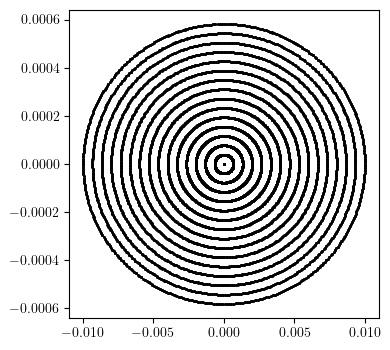

In [13]:
# Plot trajectories

plt.figure(figsize=(4, 4))
plt.scatter(qx.cpu().numpy(), px.cpu().numpy(), s=1, color='black')
plt.show()

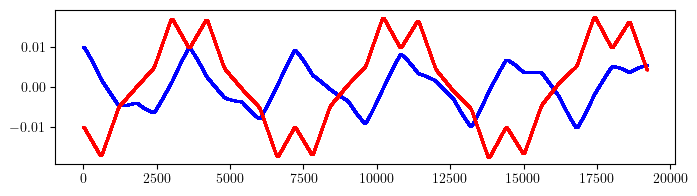

CPU times: user 13.7 s, sys: 149 ms, total: 13.8 s
Wall time: 13.7 s


In [14]:
%%time

# Output can be collected at each integration step
# Note, container is overwritten at each call

FODO.ns = 0.01
FODO.output = True

state = torch.tensor([+0.01, 0.0, -0.01, 0.0], dtype=torch.float64)
orbit = []
for _ in range(16):
    state = FODO(state)
    orbit.append(FODO.container_output)
qx, _, qy, _  = torch.vstack(orbit).T

plt.figure(figsize=(8, 2))
plt.scatter(range(len(qx)), qx.cpu().numpy(), s=1, color='blue')
plt.scatter(range(len(qy)), qy.cpu().numpy(), s=1, color='red')
plt.show()

In [15]:
%%time

# Functions can be compiled, but note that dynamo unrolls loops completely (torch 2.4)
# This leads to very long compilation times

FODO.ns = 1

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
table = 1.0E-3*torch.randn((512, 4), dtype=FODO.dtype, device=FODO.device)

fodo = torch.compile(FODO)
fodo(state)

CPU times: user 13.3 s, sys: 3.99 s, total: 17.2 s
Wall time: 20.7 s


tensor([0., 0., 0., 0.], dtype=torch.float64)

In [16]:
%%timeit

FODO(state)

3.98 ms ± 9.28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit

fodo(state)

364 µs ± 1.43 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
%%timeit

_ = torch.vmap(FODO)(table)

7.49 ms ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit

_ = torch.vmap(fodo)(table)

7.55 ms ± 22.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
# Note, compositional operations (map or jacobian seems to break/ignore compiled version)

In [21]:
# name (property)
# This property can be used to get/set line name

FODO.name

'FODO'

In [22]:
# sequence (property)
# Contains ordered sequence of elements
# Elements can be added or removed from it

len(FODO.sequence)

18

In [23]:
# unique (property)
# name: (type, length, angle) data for all unique elements

FODO.unique

{'QF': ('Quadrupole',
  tensor(0.5000, dtype=torch.float64),
  tensor(0., dtype=torch.float64)),
 'DR': ('Drift',
  tensor(0.2500, dtype=torch.float64),
  tensor(0., dtype=torch.float64)),
 'SF': ('Sextupole',
  tensor(0.2500, dtype=torch.float64),
  tensor(0., dtype=torch.float64)),
 'BM': ('Dipole',
  tensor(3.5000, dtype=torch.float64),
  tensor(0.3927, dtype=torch.float64)),
 'SD': ('Sextupole',
  tensor(0.2500, dtype=torch.float64),
  tensor(0., dtype=torch.float64)),
 'QD': ('Quadrupole',
  tensor(0.5000, dtype=torch.float64),
  tensor(0., dtype=torch.float64))}

In [24]:
# length (property)

FODO.length

tensor(12., dtype=torch.float64)

In [25]:
# angle (property)

FODO.angle

tensor(0.7854, dtype=torch.float64)

In [26]:
# ns (property)
# This property can be used to get/set number of integration steps to unique elements

# Set value integration steps to all elements

FODO.ns = 10
print(FODO.ns)

# Set ceil(element.length/value) integration steps to each element

FODO.ns = 0.1
print(FODO.ns)

# Set by name or type

FODO.ns = (('DR', 1), ('Sextupole', 0.01))
print(FODO.ns)

{'QF': 10, 'DR': 10, 'SF': 10, 'BM': 10, 'SD': 10, 'QD': 10}
{'QF': 5, 'DR': 3, 'SF': 3, 'BM': 35, 'SD': 3, 'QD': 5}
{'QF': 5, 'DR': 1, 'SF': 25, 'BM': 35, 'SD': 25, 'QD': 5}


In [27]:
# order (property)
# This property can be used to get/set integration order to unique elements

# Set value integration steps to all elements

FODO.order = 0
print(FODO.order)

# Set by name or type

FODO.order = (('BM', 1), ('Sextupole', 1))
print(FODO.order)

{'QF': 0, 'DR': 0, 'SF': 0, 'BM': 0, 'SD': 0, 'QD': 0}
{'QF': 0, 'DR': 0, 'SF': 1, 'BM': 1, 'SD': 1, 'QD': 0}


In [28]:
# Nested lines
# Note, flags for lines are not propagated

FODO = Line('FODO', [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], propagate=True, dp=0.0, exact=False, output=False, matrix = False)
RING = Line('RING', 8*[FODO], propagate=True, dp=0.0, exact=False, output=False, matrix = False)

RING.ns = 1
print(RING.ns)

RING.order = 0
print(RING.order)

# Note, sublines are not flattened

print(len(RING.sequence))

{'QF': 1, 'DR': 1, 'SF': 1, 'BM': 1, 'SD': 1, 'QD': 1}
{'QF': 0, 'DR': 0, 'SF': 0, 'BM': 0, 'SD': 0, 'QD': 0}
8


In [29]:
# Tracking, mapping and differentiation is similar to flat lines

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
RING(state)

tensor([0., 0., 0., 0.], dtype=torch.float64)

In [30]:
# Deviation table contains unique lines with unique elements (unique by names)

RING.table(alignment=False)

{'FODO': {'QF': {'kn': tensor(0., dtype=torch.float64),
   'ks': tensor(0., dtype=torch.float64),
   'dp': tensor(0., dtype=torch.float64),
   'dl': tensor(0., dtype=torch.float64)},
  'DR': {'dp': tensor(0., dtype=torch.float64),
   'dl': tensor(0., dtype=torch.float64)},
  'SF': {'ms': tensor(0., dtype=torch.float64),
   'dp': tensor(0., dtype=torch.float64),
   'dl': tensor(0., dtype=torch.float64)},
  'BM': {'dw': tensor(0., dtype=torch.float64),
   'e1': tensor(0., dtype=torch.float64),
   'e2': tensor(0., dtype=torch.float64),
   'kn': tensor(0., dtype=torch.float64),
   'ks': tensor(0., dtype=torch.float64),
   'ms': tensor(0., dtype=torch.float64),
   'mo': tensor(0., dtype=torch.float64),
   'dp': tensor(0., dtype=torch.float64),
   'dl': tensor(0., dtype=torch.float64)},
  'SD': {'ms': tensor(0., dtype=torch.float64),
   'dp': tensor(0., dtype=torch.float64),
   'dl': tensor(0., dtype=torch.float64)},
  'QD': {'kn': tensor(0., dtype=torch.float64),
   'ks': tensor(0., dtype=t

In [31]:
# If this can be used to pass different values of deviation variables to unique elements
# But values should match for consistent differentiation

LA = Line('LA', [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], propagate=True, dp=0.0, exact=False, output=False, matrix = False)
LB = Line('LB', [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], propagate=True, dp=0.0, exact=False, output=False, matrix = False)

RING = Line('RING', [LA, LB], propagate=True, dp=0.0, exact=False, output=False, matrix = False)

state = torch.tensor([0.01, 0.0, 0.01, 0.0], dtype=torch.float64)

kn = torch.tensor(0.01, dtype=torch.float64)

data = RING.table()

data['LA']['QF']['kn'] = kn
data['LB']['QF']['kn'] = kn

print(RING(state, data=data))

kna = torch.tensor(+0.01, dtype=torch.float64)
knb = torch.tensor(-0.01, dtype=torch.float64)

data['LA']['QF']['kn'] = kna
data['LB']['QF']['kn'] = knb

print(RING(state, data=data))

tensor([-0.0047,  0.0005, -0.0045, -0.0014], dtype=torch.float64)
tensor([-0.0055,  0.0005, -0.0048, -0.0014], dtype=torch.float64)


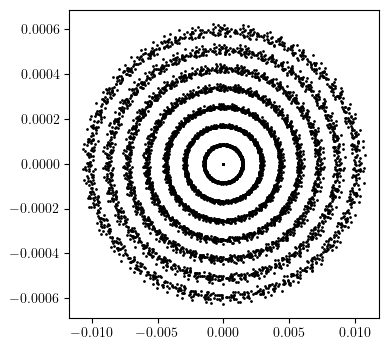

In [32]:
# Modulation

FODO = Line('FODO', [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], propagate=True, dp=0.0, exact=False, output=False, matrix = False)

dkf = 1.0E-3*torch.randn(2**10, dtype=torch.float64)
dkd = 1.0E-3*torch.randn(2**10, dtype=torch.float64)

qx = torch.linspace(0.0, 0.01, 8, dtype=torch.float64)
px = torch.zeros_like(qx)
qy = torch.zeros_like(qx)
py = torch.zeros_like(qx)

state = torch.stack([qx, px, qy, py]).T
orbit = []

data = FODO.table()

for i in range(2**10):
    data['QF']['kn'] = dkf[i]
    data['QD']['kn'] = dkd[i]
    state = torch.vmap(lambda state: FODO(state, data=data))(state)
    orbit.append(state)

qx, px, *_ = torch.stack(orbit).swapaxes(0, -1)

plt.figure(figsize=(4, 4))
plt.scatter(qx.cpu().numpy(), px.cpu().numpy(), s=1, color='black')
plt.show()

In [33]:
# Nested alignment (test without bending)

QF = Quadrupole('QF', 0.5, +0.25)
QD = Quadrupole('QD', 0.5, -0.20)
SF = Sextupole('SF', 0.25)
SD = Sextupole('SD', 0.25)
DR = Drift('DR', 0.25)
BM = Drift('BM', 3.50)

FODO = Line('FODO', [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], propagate=True, dp=0.0, exact=False, output=False, matrix = False)

state = torch.tensor([+0.01, 0.0, -0.01, 0.0], dtype=torch.float64)

dx = torch.tensor(0.01, dtype=torch.float64)

dx_qf = torch.tensor(0.01, dtype=torch.float64)
dx_qd = torch.tensor(0.01, dtype=torch.float64)

# 2x quadrupoles

data = FODO.table()
data['dx'] = 0*dx
data['QF']['dx'] = 2*dx_qf
data['QD']['dx'] = 2*dx_qd

print(FODO(state, data=data, alignment=True).tolist())

# 1x quadrupoles and 1x fodo

data['dx'] = 1*dx
data['QF']['dx'] = 1*dx_qf
data['QD']['dx'] = 1*dx_qd

print(FODO(state, data=data, alignment=True).tolist())

[0.02090725772744483, 0.0005430498651489654, -0.004962609791574424, 0.0014062973408549748]
[0.02090725772744481, 0.0005430498651489672, -0.004962609791574424, 0.0014062973408549748]


tensor([[-0.4395, 15.4433,  0.0000,  0.0000],
        [-0.0522, -0.4395,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.4963,  5.3596],
        [ 0.0000,  0.0000, -0.1406,  0.4963]], dtype=torch.float64)

tensor([[-0.4395, 15.4433,  0.0000,  0.0000],
        [-0.0522, -0.4395,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.4963,  5.3596],
        [ 0.0000,  0.0000, -0.1406,  0.4963]], dtype=torch.float64)



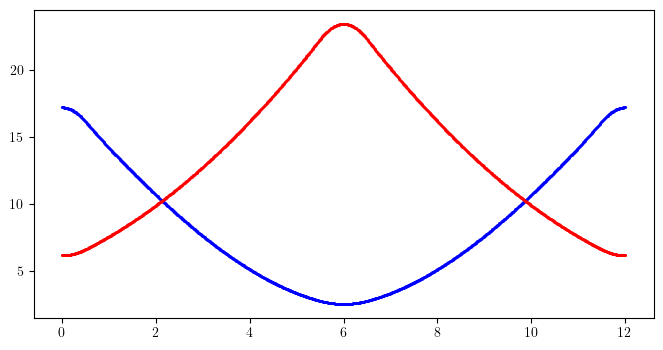

In [34]:
# Matrix output and twiss parameters

from twiss import twiss
from twiss import propagate
from twiss import wolski_to_cs

QF = Quadrupole('QF', 0.5, +0.25)
QD = Quadrupole('QD', 0.5, -0.20)
SF = Sextupole('SF', 0.25)
SD = Sextupole('SD', 0.25)
DR = Drift('DR', 0.25)
BM = Dipole('BM', 3.50, torch.pi/8.0)

FODO = Line('FODO', [QF, DR, SF, DR, BM, DR, SD, DR, QD, QD, DR, SD, DR, BM, DR, SF, DR, QF], propagate=True, matrix=True)
FODO.ns = 0.01

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

print(torch.func.jacrev(FODO)(state))
print()

out, *ms = FODO.container_matrix
for m in ms:
   out = m @ out
print(out)
print()

*_, w = twiss(out)
ws = [w]

for m in FODO.container_matrix:
    w = propagate(w, m)
    ws.append(w)

ws = torch.stack(ws)

_, bx, _, by = torch.vmap(wolski_to_cs)(ws).T

s = torch.linspace(0.0, 12.0, len(bx), dtype=torch.float64)

plt.figure(figsize=(8, 4))
plt.scatter(s.cpu().numpy(), bx.cpu().numpy(), s=1, color='blue')
plt.scatter(s.cpu().numpy(), by.cpu().numpy(), s=1, color='red')
plt.show()